# <span style="color:green">Network of Co-Occurring Words (Word-Net) in 4 Novels of Sherlock Holmes

In the four novels A Study In Scarlet, The Hound of the Baskervilles, The Valley of Fear, and The Sign of the Four by author Arthur Conan Doyle, private detective Sherlock Holmes is a recurring main character who tackles investigative cases for a wide range of clients. In this project we use text and network analysis methods to understand how character and location relationships in each novel are captured using these methods. In particular, sentential co-occurrence of character, location, and event entities is the focus of this project.

In [1]:
# !python -m spacy download en_core_web_lg

!sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

import time
start_time = time.perf_counter()
import urllib, os, codecs, random, operator, re, string, copy, dateutil.parser, itertools, pickle, datetime, math, pandas as pd, numpy as np, matplotlib.pyplot as plt
from collections import Counter
from string import punctuation, digits
import pathlib
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_lg')
import inflect
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
from wordcloud import WordCloud
import matplotlib as mpl
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.simplefilter('ignore')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
python-dev is already the newest version (2.7.15~rc1-1).
graphviz is already the newest version (2.40.1-2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 25 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://arch

### Load Data

In [2]:
# get your working directory
home = str(pathlib.Path.cwd())

# create a path to which the file will be written
text1_path = os.path.join(home, 'scarlet.txt')
text2_path = os.path.join(home, 'baskervilles.txt')
text3_path = os.path.join(home, 'valley.txt')
text4_path = os.path.join(home, 'sign.txt')

titlename1 = "A. Conan Doyle's 'A Study in Scarlet'"
titlename2 = "A. Conan Doyle's 'The Hound of the Baskervilles'"
titlename3 = "A. Conan Doyle's 'The Valley of Fear'"
titlename4 = "A. Conan Doyle's 'The Sign of the Four'"

#location of the project gutenberg copy of the moby-dick text file
text1_url = 'https://www.gutenberg.org/files/244/244-0.txt'
text2_url = 'http://www.gutenberg.org/cache/epub/3070/pg3070.txt'
text3_url = 'http://www.gutenberg.org/cache/epub/3776/pg3776.txt'
text4_url = 'https://www.gutenberg.org/files/2097/2097-0.txt'

urllib.request.urlretrieve(text1_url, text1_path)
urllib.request.urlretrieve(text2_url, text2_path)
urllib.request.urlretrieve(text3_url, text3_path)
urllib.request.urlretrieve(text4_url, text4_path)

print('Downloaded to:', text1_path)
print('Downloaded to:', text2_path)
print('Downloaded to:', text3_path)
print('Downloaded to:', text4_path)

Downloaded to: /content/scarlet.txt
Downloaded to: /content/baskervilles.txt
Downloaded to: /content/valley.txt
Downloaded to: /content/sign.txt


In [0]:
def cleanText(text,text_path,titlename,start,end):
    f = codecs.open(text_path, "r", encoding="utf-8").readlines()
    ff=f[start:end]
    ctext="\r\n".join(ff)
    words = word_tokenize(ctext)
    nuw=len(words)
    uw=len(set(words))
    print("%s contains %i nonunique and %i unique words" %(titlename,nuw,uw))
    return ctext

### 1. A Study in Scarlet

In [4]:
text='scarlet.txt'
text_path=text1_path
titlename = titlename1
start=69
end=4712
text1=cleanText(text,text_path,titlename,start,end)

A. Conan Doyle's 'A Study in Scarlet' contains 51721 nonunique and 6434 unique words


### 2. The Hound of the Baskervilles

In [5]:
text='baskervilles.txt'
text_path=text2_path
titlename = titlename2
start=60
end=7359
text2=cleanText(text,text_path,titlename,start,end)

A. Conan Doyle's 'The Hound of the Baskervilles' contains 70060 nonunique and 6084 unique words


### 3. The Valley of Fear

In [6]:
text='valley.txt'
text_path=text3_path
titlename = titlename3
start=74
end=6884
text3=cleanText(text,text_path,titlename,start,end)

A. Conan Doyle's 'The Valley of Fear' contains 70137 nonunique and 6206 unique words


### 4. The Sign of the Four

In [7]:
text='sign.txt'
text_path=text4_path
titlename = titlename4
start=55
end=4557
text4=cleanText(text,text_path,titlename,start,end)

A. Conan Doyle's 'The Sign of the Four' contains 51528 nonunique and 6184 unique words


### Extraction of Proper Nouns

In [0]:
# TYPE          DESCRIPTION
# PERSON        People, including fictional.
# NORP          Nationalities or religious or political groups.
# FAC           Buildings, airports, highways, bridges, etc.
# ORG           Companies, agencies, institutions, etc.
# GPE           Countries, cities, states.
# LOC           Non-GPE locations, mountain ranges, bodies of water.
# PRODUCT       Objects, vehicles, foods, etc. (Not services.)
# EVENT         Named hurricanes, battles, wars, sports events, etc.
# WORK_OF_ART   Titles of books, songs, etc.
# LAW           Named documents made into laws.
# LANGUAGE      Any named language.
# DATE          Absolute or relative dates or periods.
# TIME          Times smaller than a day.
# PERCENT       Percentage, including ”%“.
# MONEY         Monetary values, including unit.
# QUANTITY      Measurements, as of weight or distance.
# ORDINAL       “first”, “second”, etc.
# CARDINAL      Numerals that do not fall under another type.

In [0]:
def nameExtraction(novel,text,removed,added):
    p = inflect.engine()
    d_tags = {}
    docs_d={novel:text}
    for key, value in docs_d.items():
        arr = []
        doc = nlp(value.replace('\n',''))
        #Keep these types of nlp entities
        keep_l = ['PERSON','NORP','GPE','LOC','EVENT']
        #Typo/model error + german corrections
        drop_t = []
        #Things inflect library handles poorly or to exclude from touching
        ex_ls = []
        for X in doc.ents:
            s1 = X.text
            if (X.label_ in keep_l) and (s1.lower() not in drop_t) and (s1):
                arr.append((s1, X.label_))
        d_tags[key] = arr
    # pprint(d_tags)
    names=[]
    for k,v in d_tags.items():
        for vv in v:
            if vv[0] not in names:
                p=vv[0].replace("'","").replace("’","")
                p=p.title()
                names.append(p)
    rem=[]
    for p in names:
        if "_" in p:
            rem.append(p)
        if "--" in p:
            rem.append(p)
        if p not in text:
            rem.append(p)
    names=[p for p in names if p not in rem]
    pp=[q for q in itertools.product(names,names) if q[0]!=q[1]]
    for q in pp:
        if q[0] in q[1]:
            rem.append(q[0])
        if q[1] in q[0]:
            rem.append(q[1])
        w=q[0]+" "+q[1]
        if w in text:
            names.append(w)
            rem.append(q[0])
            rem.append(q[1])
    names=[p for p in names if p not in rem]
    names=[p for p in names if p not in removed]
    names=names+added
    names=[p for p in names if p in text]
    names=sorted(set(names)) 
    return names

def frequencyDF(text,names):
    nfreq=[]
    for i in names: 
        nfreq.append(text.count(i))
    pnf_df = pd.DataFrame(
        {'Proper Nouns': names, 
         'Frequency of Occurrences': nfreq
        })
    pnf_df=pnf_df[['Proper Nouns','Frequency of Occurrences']]
    pnf_df=pnf_df.sort_values(by ='Frequency of Occurrences',ascending=False)
    return pnf_df

In [0]:
removed=['Ye','Sherlock Holmes’','M.D.','J. H.','Nature','West','C.C.H.',
        'I. "','Hist','Hunt','L. L.','M.R.C.S.','Mlle','Mme','States',
        'The County','Americans','Boss Mac','Californians','Captain Marvin',
        'Central','Darkness','Deviltry','Douglases','Editor Stanger','Friend Porlock',
        'Gar','I. He','Jack Douglas','Lodge 29','Lodge 341','North','Patch',
        'Hobson','Spare','Stile','Teddy Baldwin','Ted Baldwin','God',
        'Andaman Islander','Andaman Islands','Arabs','Atheney Jones',
        'I. Lal Chowdar','W.','I. “Friend Sholto','Lost.—Whereas Mordecai Smith',
        'Moonlight','Brazils','Christians','Continent',
        'Eastern','Europeans','Indians','Mohammedans','Peninsula',
        'Oriental','Queen','Sholtos','Sikhs',
        'The Great Agra Treasure','I.','Stapletons','Morstan','I. M','Mac',
         'Joseph Stangerson','Bartholomew Sholto','Thaddeus Sholto','Sholto','Au','Baker']
added=["Sherlock Holmes",'United States','County Constabulary','American',
      'McGinty','Scott','Californian','Marvin','Douglas','Porlock',
      "Hobson's Patch",'Baldwin','Andaman Island','Arab','Lal Chowdar',
      'Mordecai Smith','Agra','Brazil','European','Indian',
      'Mohammedan','Sikh','Smith',
       'Stamford','Gregson','Madame Charpentier','Stangerson',
      'Miss Stapleton', 'Mr. Stapleton','Mrs. Barrymore','MacDonald','Mrs. Douglas',
       'Fred Porlock','Miss Morstan','Captain Morstan','Holmes','Bartholomew','Thaddeus',
       'Mr. Sholto','Major Sholto','John Sholto','Baker Street','Mrs. Smith']

### 1. A Study in Scarlet

In [11]:
novel="Scarlet"
text=text1

names1=nameExtraction(novel,text,removed,added)
print(len(names1))
names1

146


['Afghanistan',
 'Alice',
 'American',
 'American Continent',
 'Anglo-Saxon',
 'Arab',
 'Arthur Charpentier',
 'Atlantic',
 'Baker Street',
 'Bender',
 'Berkshires',
 'Blackfeet',
 'Bob',
 'Bombay',
 'Boots',
 'Bradford',
 'Brigham Young',
 'British',
 'Brixton M',
 'Bunsen',
 'California',
 'Camberwell',
 'Candahar',
 'Carbonari',
 'Carson',
 'Charles',
 'Chopin',
 'Christian',
 'Cleveland',
 'Colorado',
 'Commissionaire',
 'Copenhagen',
 'Cowper',
 'Danish',
 'Darwinian',
 'Dolsky',
 'Duncan Street',
 'Dupin',
 'E. J. Drebber',
 'Egyptian',
 'England',
 'English',
 'Enoch Drebber',
 'Enoch J. Drebber',
 'Europe',
 'Euston',
 'Ferriers',
 'Frankfort',
 'Gaboriau',
 'German',
 'Gregson',
 'Guiacum',
 'Guliolmi Whyte',
 'Halliday',
 'Harry Murcher',
 'Henri Murger',
 'Holborn',
 'Holland Grove',
 'Holmes',
 'Houndsditch',
 'Illinois',
 'Indian',
 'Ipse',
 'Jew',
 'John Ferrier',
 'John Rance',
 'John Underwood',
 'Johnny Hones',
 'Johnston',
 'Joseph Smith',
 'Kemball',
 'Latin',
 'Laur

In [12]:
names=names1
fdf=frequencyDF(text,names)
print(len(fdf))
fdf.head(30)

146


Proper Nouns  Frequency of Occurrences
58              Holmes                        94
74            Lestrade                        47
125         Stangerson                        47
50             Gregson                        43
118    Sherlock Holmes                        40
64        John Ferrier                        25
124           Stamford                        11
2             American                        10
28           Cleveland                         9
88             Mormons                         9
135               Utah                         8
116     Salt Lake City                         8
79        Lucy Ferrier                         8
49              German                         8
0          Afghanistan                         7
61              Indian                         6
140             Watson                         6
8         Baker Street                         6
1                Alice                         5
45              Euston                         5
53            Halliday                         5
44              Europe                         4
43    Enoch J. Drebber                         4
72   Lauriston Gardens                         4
42       Enoch Drebber                         4
76           Liverpool                         4
14               Boots                         4
132       Trichinopoly                         4
141            Wiggins                         4
69        Joseph Smith                         3

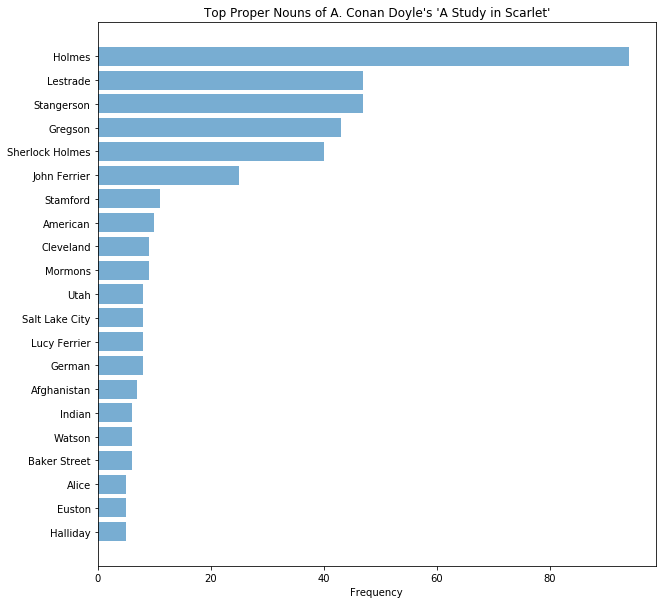

In [13]:
x = fdf.set_index('Proper Nouns').T.to_dict() 
x=sorted([(k,v['Frequency of Occurrences']) for k,v in x.items()], key=lambda x: x[1],reverse=True)
keys = [i for (i,j) in x if j>4] 
y_pos = np.arange(len(keys))
performance = [j for (i,j) in x if j>4] 
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.barh(y_pos, performance, align='center', alpha=0.6) 
ax.invert_yaxis()
plt.yticks(y_pos, keys)
plt.xlabel('Frequency')
ss="Top Proper Nouns of %s" %titlename1
plt.title(ss)
plt.show()

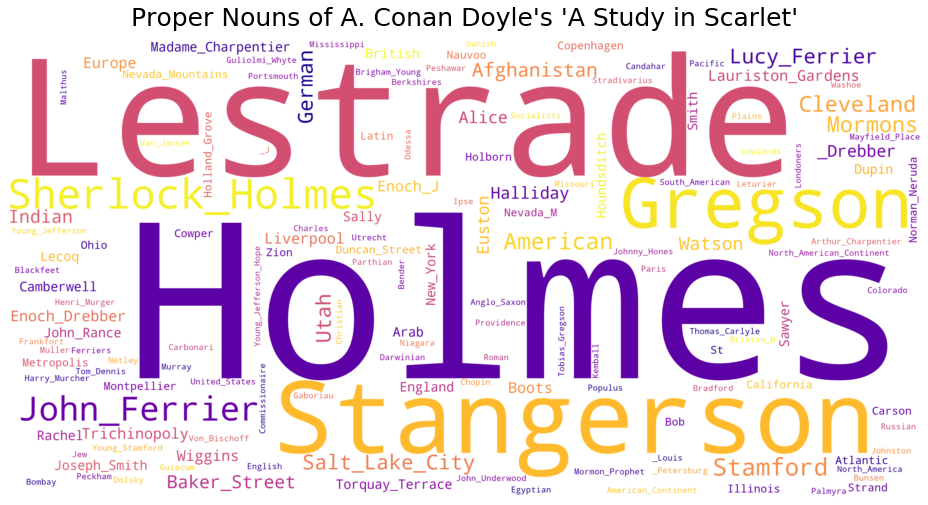

In [14]:
t=[]
for (i,j) in x:
    for k in range(j):
#         print i.replace(" ","_").replace("-","_")
        t.append(i.replace(" ","_").replace("-","_"))
ttd=' '.join(t)
wordcloud = WordCloud(collocations=False,background_color="white",colormap="plasma",width=4000,height=2000).generate(ttd)
fig = plt.figure(figsize=(13,13))
default_colors = wordcloud.to_array()
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
ss="Proper Nouns of %s" %titlename1
plt.suptitle(ss,fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 1.4]) 
plt.show()

### 2. The Hound of the Baskervilles

In [15]:
novel="Baskervilles"
text=text2
# removed=['Ye','Sherlock Holmes’','M.D.','J. H.','Nature','West','C.C.H.',
#         'I. "','Hist','Hunt','L. L.','M.R.C.S.','Mlle','Mme','States',
#         'The County']
# added=["Sherlock Holmes",'United States','County Constabulary']
names2=nameExtraction(novel,text,removed,added)
print(len(names2))
names2

107


['Alton',
 'American',
 'Anderson',
 'Anthony',
 'Antonio',
 'Baker Street',
 'Barrymore',
 'Baskervilles',
 'Belgian',
 'Beryl Garcia',
 'Black Tor',
 'Borough',
 'Bradley',
 'British',
 'Bushman',
 'Canada',
 'Cartwright',
 'Carére',
 'Celtic',
 'Charles Baskerville',
 'Christian',
 'Clarendon',
 'Coombe Tracey',
 'Costa Rica',
 'Dartmoor',
 'Desmonds',
 'Devonshire',
 'Edison',
 'Elizabethan',
 'England',
 'Esquimau',
 'Europe',
 'Fernworthy',
 'Foulmire',
 'Frankland',
 'Fraser',
 'French',
 'George',
 'German',
 'Grimpen Mire',
 'Halloa',
 'Henry Baskerville',
 'Holmes',
 'Holy Writ',
 'Hugo Baskerville',
 'Jack',
 'James Desmond',
 'James Mortimer',
 'John Clayton',
 'John Morland',
 'Laura Lyons',
 'Lestrade',
 'Liberal',
 'Little Russia',
 'London',
 'Long Down',
 'Mangles',
 'Merripit House',
 'Meyers',
 'Middleton',
 'Miss Stapleton',
 'Montpensier',
 'Mr. Stapleton',
 'Mrs. Barrymore',
 'Murphy',
 'Newcastle',
 'North Carolina',
 'North Devon',
 'Notting',
 'Oldmore',
 'Oxfo

In [16]:
names=names2
fdf=frequencyDF(text,names)
print(len(fdf))
fdf.head(30)

107


Proper Nouns  Frequency of Occurrences
42                Holmes                       191
100               Watson                       114
6              Barrymore                        79
54                London                        49
84       Sherlock Holmes                        27
41     Henry Baskerville                        19
34             Frankland                        18
22         Coombe Tracey                        17
19   Charles Baskerville                        15
26            Devonshire                        14
83                Selden                        13
29               England                        13
39          Grimpen Mire                        13
5           Baker Street                        12
7           Baskervilles                        12
60        Miss Stapleton                        11
50           Laura Lyons                        11
57        Merripit House                        11
93                 Times                        10
104            Yew Alley                        10
51              Lestrade                         9
16            Cartwright                         8
40                Halloa                         7
24              Dartmoor                         6
63        Mrs. Barrymore                         5
62         Mr. Stapleton                         5
47        James Mortimer                         5
73               Perkins                         5
76            Princetown                         5
99              Waterloo                         5

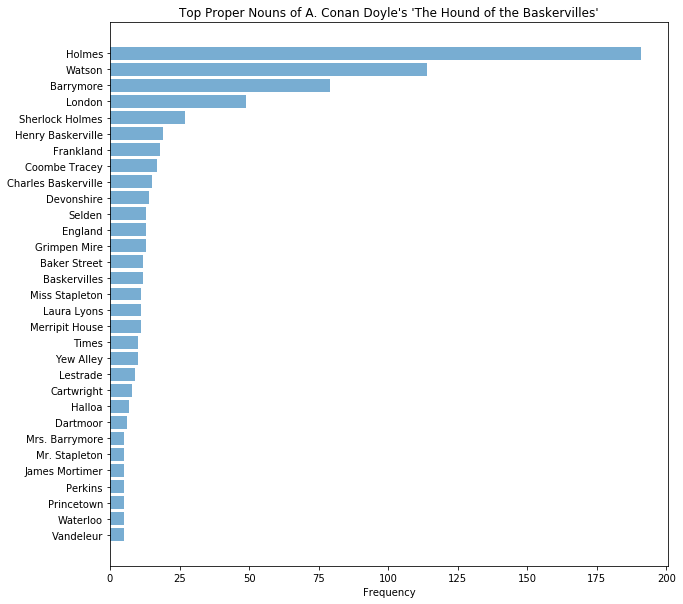

In [17]:
x = fdf.set_index('Proper Nouns').T.to_dict() 
x=sorted([(k,v['Frequency of Occurrences']) for k,v in x.items()], key=lambda x: x[1],reverse=True)
keys = [i for (i,j) in x if j>4] 
y_pos = np.arange(len(keys))
performance = [j for (i,j) in x if j>4] 
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.barh(y_pos, performance, align='center', alpha=0.6) 
ax.invert_yaxis()
plt.yticks(y_pos, keys)
plt.xlabel('Frequency')
ss="Top Proper Nouns of %s" %titlename2
plt.title(ss)
plt.show()

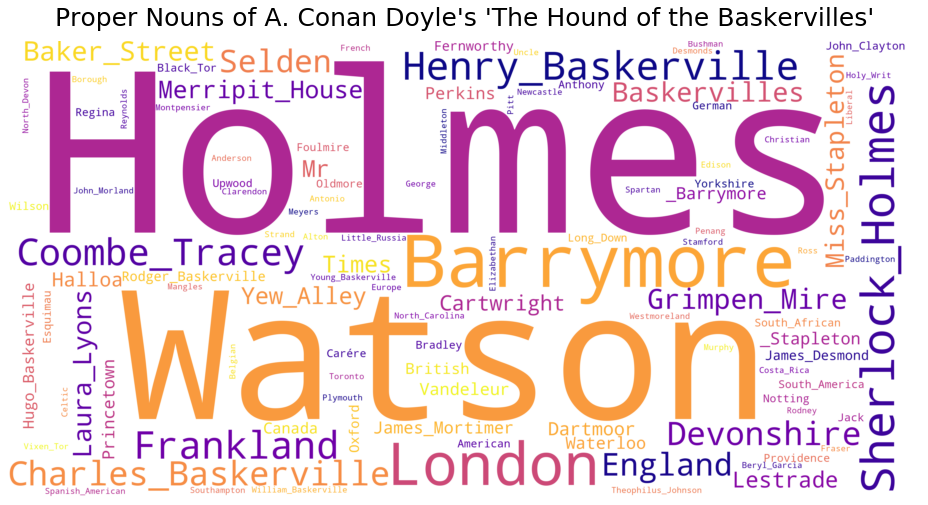

In [18]:
t=[]
for (i,j) in x:
    for k in range(j):
#         print i.replace(" ","_").replace("-","_")
        t.append(i.replace(" ","_").replace("-","_"))
ttd=' '.join(t)
wordcloud = WordCloud(collocations=False,background_color="white",colormap="plasma",width=4000,height=2000).generate(ttd)
fig = plt.figure(figsize=(13,13))
default_colors = wordcloud.to_array()
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
ss="Proper Nouns of %s" %titlename2
plt.suptitle(ss,fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 1.4]) 
plt.show()

### 3. The Valley of Fear

In [19]:
novel="Valley"
text=text3
# removed=['Ye','Sherlock Holmes’','M.D.','J. H.','Nature','West','C.C.H.',
#         'I. "','Hist','Hunt','L. L.','M.R.C.S.','Mlle','Mme','States',
#         'The County','Americans','Boss Mac','Californians','Captain Marvin',
#         'Central','Darkness','Deviltry','Douglases','Editor Stanger','Friend Porlock',
#         'Gar','I. He','Jack Douglas','Lodge 29','Lodge 341','North','Patch',
#         'Hobson','Spare','Stile','Teddy Baldwin','Ted Baldwin',]
# added=["Sherlock Holmes",'United States','County Constabulary','American',
#       'McGinty','Scott','Californian','Marvin','Douglas','Porlock',
#       "Hobson's Patch",'Baldwin']
names3=nameExtraction(novel,text,removed,added)
print(len(names3))
names3

156


['Aberdonian',
 'Allen',
 'American',
 'Ames',
 'Andrew Rae',
 'Andrews',
 'Archie Swindon',
 'Arthur Willaby',
 'Atwood',
 'Baker Street',
 'Baldwin',
 'Bartholomew',
 'Bartholomew Wilson',
 'Benito Canyon',
 'Billy',
 'Birdy Edwards',
 'Birlstone Manor House',
 'Boarder',
 'Bodymaster',
 'Bradshaw',
 'Brethren',
 'British',
 'Californian',
 'Cape Town',
 'Capus',
 'Carter',
 'Catholic',
 'Cecil Barker',
 'Cecil James Barker',
 'Charles Chandos',
 'Charlie Williams',
 'Chester Wilcox',
 'Chicago',
 'Chinese',
 'Crabbe',
 'Danton',
 'Detroit',
 'Douglas',
 'East Ham',
 'Egan',
 'English',
 'Ettie Edwards',
 'Ettie Shafter',
 'Europe',
 'Evans Pott',
 'Foreman Blaker',
 'Fred',
 'Freeman',
 'Freemen',
 'French',
 'George',
 'Germany',
 'Gilmerton',
 'Gower',
 'Greek',
 'Hampstead',
 'Hargrave',
 'Harraway',
 'Helmdale',
 'Herman Strauss',
 "Hobson's Patch",
 'Holmes',
 'Hudson',
 'Hyam',
 'India',
 'Inner Deacon',
 'Irishman',
 'Ironhill',
 'Italian',
 'Jack Knox',
 'Jacob Shafter',
 'J

In [20]:
names=names3
fdf=frequencyDF(text,names)
print(len(fdf))
fdf.head(30)

156


Proper Nouns  Frequency of Occurrences
61            Holmes                       150
37           Douglas                       112
97           McGinty                        95
151           Watson                        55
10           Baldwin                        49
91         MacDonald                        39
18        Bodymaster                        37
104           Morris                        36
32           Chicago                        34
3               Ames                        33
105     Mrs. Douglas                        27
152      White Mason                        25
122         Scowrers                        22
2           American                        18
89            London                        18
103         Moriarty                        15
114          Porlock                        15
27      Cecil Barker                        15
95            Marvin                        14
113        Pinkerton                        13
15     Birdy Edwards                        13
124  Sherlock Holmes                        11
40           English                        11
1              Allen                        10
79      John Douglas                        10
48           Freemen                         9
47           Freeman                         8
60    Hobson's Patch                         7
85            Lawler                         6
5            Andrews                         5

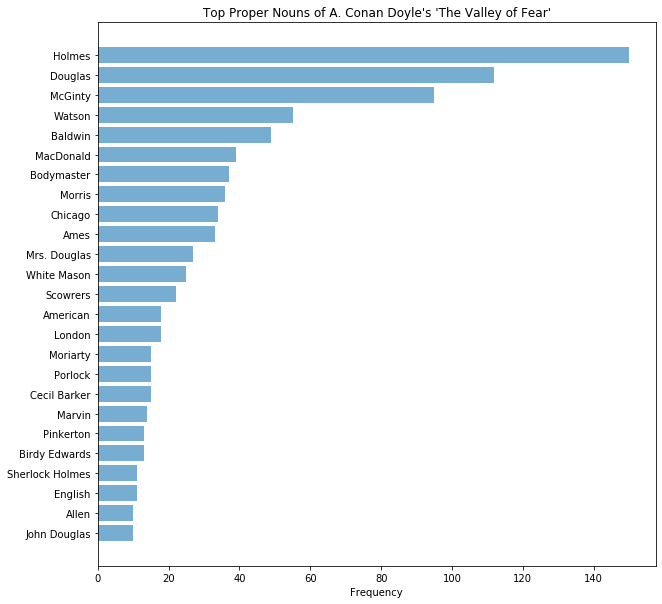

In [21]:
x = fdf.set_index('Proper Nouns').T.to_dict() 
x=sorted([(k,v['Frequency of Occurrences']) for k,v in x.items()], key=lambda x: x[1],reverse=True)
keys = [i for (i,j) in x if j>9] 
y_pos = np.arange(len(keys))
performance = [j for (i,j) in x if j>9] 
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.barh(y_pos, performance, align='center', alpha=0.6) 
ax.invert_yaxis()
plt.yticks(y_pos, keys)
plt.xlabel('Frequency')
ss="Top Proper Nouns of %s" %titlename3
plt.title(ss)
plt.show()

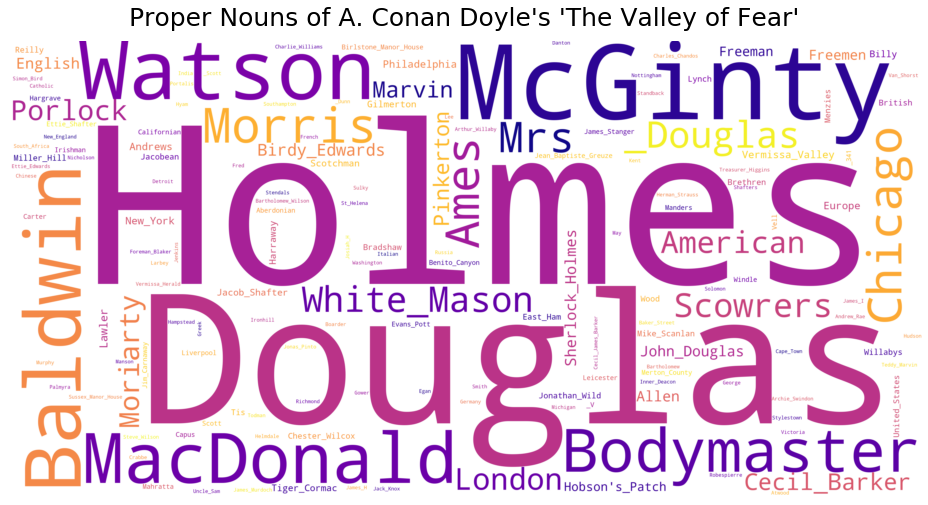

In [22]:
t=[]
for (i,j) in x:
    for k in range(j):
#         print i.replace(" ","_").replace("-","_")
        t.append(i.replace(" ","_").replace("-","_"))
ttd=' '.join(t)
wordcloud = WordCloud(collocations=False,background_color="white",colormap="plasma",width=4000,height=2000).generate(ttd)
fig = plt.figure(figsize=(13,13))
default_colors = wordcloud.to_array()
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
ss="Proper Nouns of %s" %titlename3
plt.suptitle(ss,fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 1.4]) 
plt.show()

### 4. The Sign of the Four

In [23]:
novel="Sign"
text=text4
# removed=['Ye','Sherlock Holmes’','M.D.','J. H.','Nature','West','C.C.H.',
#         'I. "','Hist','Hunt','L. L.','M.R.C.S.','Mlle','Mme','States',
#         'The County','Americans','Boss Mac','Californians','Captain Marvin',
#         'Central','Darkness','Deviltry','Douglases','Editor Stanger','Friend Porlock',
#         'Gar','I. He','Jack Douglas','Lodge 29','Lodge 341','North','Patch',
#         'Hobson','Spare','Stile','Teddy Baldwin','Ted Baldwin','God',
#         'Andaman Islander','Andaman Islands','Arabs','Atheney Jones',
#         'I. Lal Chowdar','W.','I. “Friend Sholto','Lost.—Whereas Mordecai Smith',
#         'Moonlight','Brazils','Captain Morstan','Christians','Continent',
#         'Eastern','Europeans','Indians','Mohammedans','Peninsula',
#         'Oriental','Queen','Sholtos','Sikhs','Mordecai Smith',
#         'The Great Agra Treasure',]
# added=["Sherlock Holmes",'United States','County Constabulary','American',
#       'McGinty','Scott','Californian','Marvin','Douglas','Porlock',
#       "Hobson's Patch",'Baldwin','Andaman Island','Arab','Lal Chowdar',
#       'Mordecai Smith','Agra','Brazil','Morstan','European','Indian',
#       'Mohammedan','Sholto','Sikh','Smith']
names4=nameExtraction(novel,text,removed,added)
print(len(names4))
names4

145


['Abdullah Khan',
 'Abel White',
 'Achillis',
 'Achmet',
 'Afghanistan',
 'Africa',
 'Agra',
 'Alison',
 'American',
 'Andaman Island',
 'Andamans',
 'Arab',
 'Arthur Morstan',
 'Astrakhan',
 'Athelney Jones',
 'Baker Street',
 'Ballarat',
 'Barking Level',
 'Bartholomew',
 'Beaune',
 'Bengal',
 'Bernstone',
 'Blair Island',
 'Blondin',
 'Bouguereau',
 'Brazil',
 'British',
 'Brixton',
 'Broderick',
 'Bromley Brown',
 'Buddha',
 'Bunsen',
 'Calcutta',
 'Camberwell',
 'Captain Morstan',
 'Carlyle',
 'Cawnpore',
 'Cecil Forrester',
 'Celtic',
 'Chilian',
 'Cold Harbor Lane',
 'Colin',
 'Dartmoor',
 'Dawson',
 'Delhi',
 'Dost Akbar',
 'Edinburgh',
 'England',
 'Englishman',
 'Ere',
 'European',
 'Feringhee',
 'François Le Villard',
 'Frenchman',
 'Ganges',
 'Gravesend',
 'Greathed',
 'Greek',
 'Greenwich',
 'Gregson',
 'Hindoos',
 'Hippocratic',
 'Holmes',
 'Hudson',
 'I. A',
 'I. The',
 'Indian',
 'Jack',
 'Jean Paul',
 'Jiddah',
 'Jim',
 'John Sholto',
 'Jonathan Small',
 'Kennington La

In [24]:
names=names4
fdf=frequencyDF(text,names)
print(len(fdf))
fdf.head(30)

145


Proper Nouns  Frequency of Occurrences
62              Holmes                       135
125           Thaddeus                        36
87        Miss Morstan                        34
109    Sherlock Holmes                        33
115              Smith                        28
127               Toby                        26
135             Watson                        24
18         Bartholomew                        22
6                 Agra                        22
66              Indian                        19
14      Athelney Jones                        18
112               Sikh                        16
84        Major Sholto                        14
72      Jonathan Small                        13
90          Mr. Sholto                        13
104              Sahib                        13
129              Tonga                        13
34     Captain Morstan                        12
47             England                        12
3               Achmet                        11
15        Baker Street                        10
98   Pondicherry Lodge                        10
89      Mordecai Smith                         9
126             Thames                         8
37     Cecil Forrester                         8
83       Mahomet Singh                         8
91          Mrs. Smith                         7
138            Wiggins                         6
33          Camberwell                         6
63              Hudson                         6

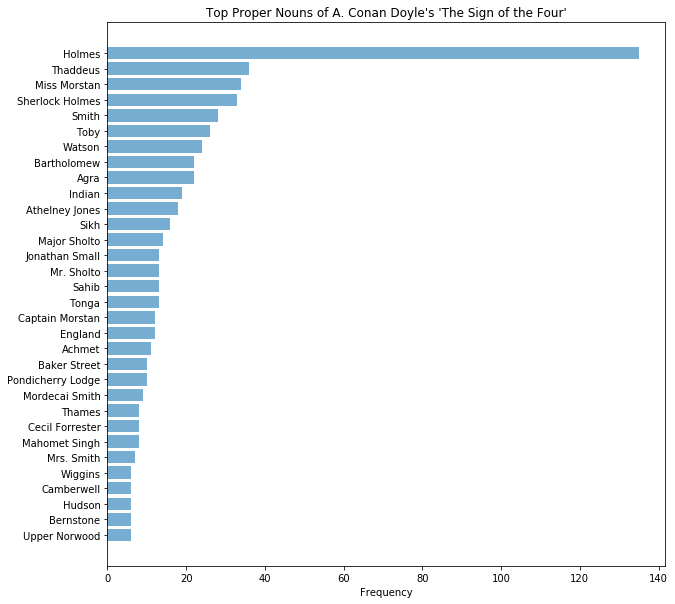

In [25]:
x = fdf.set_index('Proper Nouns').T.to_dict() 
x=sorted([(k,v['Frequency of Occurrences']) for k,v in x.items()], key=lambda x: x[1],reverse=True)
keys = [i for (i,j) in x if j>5] 
y_pos = np.arange(len(keys))
performance = [j for (i,j) in x if j>5] 
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.barh(y_pos, performance, align='center', alpha=0.6) 
ax.invert_yaxis()
plt.yticks(y_pos, keys)
plt.xlabel('Frequency')
ss="Top Proper Nouns of %s" %titlename4
plt.title(ss)
plt.show()

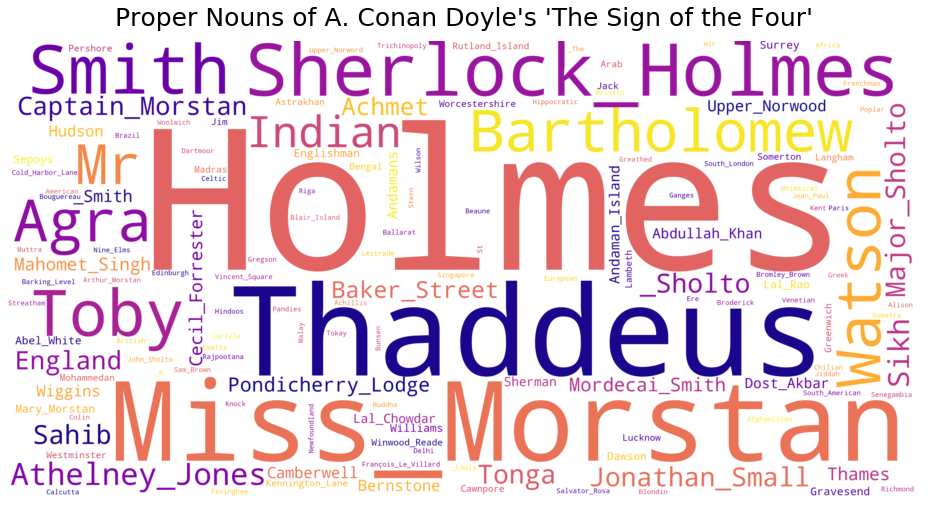

In [26]:
t=[]
for (i,j) in x:
    for k in range(j):
#         print i.replace(" ","_").replace("-","_")
        t.append(i.replace(" ","_").replace("-","_"))
ttd=' '.join(t)
wordcloud = WordCloud(collocations=False,background_color="white",colormap="plasma",width=4000,height=2000).generate(ttd)
fig = plt.figure(figsize=(13,13))
default_colors = wordcloud.to_array()
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
ss="Proper Nouns of %s" %titlename4
plt.suptitle(ss,fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 1.4]) 
plt.show()

## The Network of Sententially Co-Occurring Proper Names

### 1. A Study in Scarlet

In [0]:
text=text1
titlename=titlename1
names=names1

In [28]:
sorted(names)

['Afghanistan',
 'Alice',
 'American',
 'American Continent',
 'Anglo-Saxon',
 'Arab',
 'Arthur Charpentier',
 'Atlantic',
 'Baker Street',
 'Bender',
 'Berkshires',
 'Blackfeet',
 'Bob',
 'Bombay',
 'Boots',
 'Bradford',
 'Brigham Young',
 'British',
 'Brixton M',
 'Bunsen',
 'California',
 'Camberwell',
 'Candahar',
 'Carbonari',
 'Carson',
 'Charles',
 'Chopin',
 'Christian',
 'Cleveland',
 'Colorado',
 'Commissionaire',
 'Copenhagen',
 'Cowper',
 'Danish',
 'Darwinian',
 'Dolsky',
 'Duncan Street',
 'Dupin',
 'E. J. Drebber',
 'Egyptian',
 'England',
 'English',
 'Enoch Drebber',
 'Enoch J. Drebber',
 'Europe',
 'Euston',
 'Ferriers',
 'Frankfort',
 'Gaboriau',
 'German',
 'Gregson',
 'Guiacum',
 'Guliolmi Whyte',
 'Halliday',
 'Harry Murcher',
 'Henri Murger',
 'Holborn',
 'Holland Grove',
 'Holmes',
 'Houndsditch',
 'Illinois',
 'Indian',
 'Ipse',
 'Jew',
 'John Ferrier',
 'John Rance',
 'John Underwood',
 'Johnny Hones',
 'Johnston',
 'Joseph Smith',
 'Kemball',
 'Latin',
 'Laur

In [29]:
pre=[]
for i in range(len(names)):
    start=names[i][:4]
    pre.append(start)
for j,k in Counter(pre).items():
    if k>1:
        print(j)

Amer
Engl
Enoc
John
Miss
Morm
Neva
Nort
St. 
Stra
Youn


In [0]:
alias_dict1={}
for n in names:
    if n=='English':
        alias_dict1[n]='England'
    elif n=='England':
        alias_dict1[n]='England'
    elif n=='Enoch Drebber':
        alias_dict1[n]='Enoch Drebber'
    elif n=='Enoch J. Drebber':
        alias_dict1[n]='Enoch Drebber'
    elif n=='South America':
        alias_dict1[n]='South America'
    # elif n=='South American':
        # alias_dict1[n]='South America'
    elif n=='Young Jefferson':
        alias_dict1[n]='Young Jefferson'
    elif n=='Young Jefferson Hope':
        alias_dict1[n]='Young Jefferson'
    elif n=="Holmes":
        alias_dict1[n]="Sherlock Holmes"
#     elif n=="Lion":
#         alias_dict[n]="Lion"
#     elif n=="King of the Winged Monkeys":
#         alias_dict[n]="Monkey King"
#     elif n=="Monkey King":
#         alias_dict[n]="Monkey King"
    else:
        alias_dict1[n]=n
# print("The dictionary of aliases has %i keys (names) and %i unique values (aliased proper nouns)" %(len(alias_dict.keys()),len(set(alias_dict.values()))))
# for k,v in alias_dict.items():
#     print(k,"-->",v)

#### Sentence tokenization & sentiment analysis

In [31]:
blob = TextBlob(text)
textSentences = blob.sentences
sendic=dict()
for i,v in enumerate(textSentences):
    sent=v.sentiment.polarity
    wl=[]
    for term in list(set(alias_dict1.values())):
        if term in v: 
            wl.append(term)
    if len(wl)>1:
        sendic[i]=wl 
medges=[]
for k,v in sendic.items():
    sent=textSentences[k].sentiment.polarity
    dd={}
    ps=set()
    for j in itertools.combinations(v, 2):
        ps.add(j)
        dd[j]=(k,sent)
    for jj in ps:
        s=0
        ss=0
        for kk,vv in dd.items():
            if kk==jj:
                s+=1
                ss+=vv[1]
        if alias_dict1[jj[0]]!=alias_dict1[jj[1]]:
            medges.append((alias_dict1[jj[0]],alias_dict1[jj[1]],titlename,"Sentence_"+str(k),ss/float(s)))
print("%s contains %i sentential co-occurrences among %i aliased proper nouns"%(titlename,len(medges),len(set(alias_dict1.values()))))
medges

A. Conan Doyle's 'A Study in Scarlet' contains 162 sentential co-occurrences among 142 aliased proper nouns


[('British',
  'Murray',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_10',
  0.25),
 ('Stamford',
  'Young Stamford',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_31',
  0.025),
 ('Stamford',
  'Holborn',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_45',
  0.15),
 ('Stamford',
  'Sherlock Holmes',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_69',
  0.0),
 ('Stamford',
  'Watson',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_69',
  0.0),
 ('Sherlock Holmes',
  'Watson',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_69',
  0.0),
 ('Von Bischoff',
  'Frankfort',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_101',
  0.0),
 ('Bradford',
  'Muller',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_103',
  0.13636363636363635),
 ('Montpellier',
  'Muller',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_103',
  0.13636363636363635),
 ('Montpellier',
  'Bradford',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sent

In [0]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [33]:
medgesd=[]
for e in medges:
    d={}
    d['Novel']=e[2]
    d['Sentence']=e[3]
    d['Average sentiment']=e[4]
    medgesd.append((e[0],e[1],d))
    
# print(medgesd) 

G = nx.MultiGraph()
G.add_edges_from(medgesd)
for e in G.edges(data=True):
    if e[0]==e[1]:
        G.remove_edge(e[0],e[1])
# print(G.edges(data=True))
weight={(x,y):v for (x, y), v in Counter(G.edges()).items()}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
Gw = nx.Graph()
Gw.add_weighted_edges_from(w_edges)
# titlea={}
# for k in Gw.edges():
#     titlea[k]=titlename1
# nx.set_edge_attributes(Gw, 'Novel', titlea)
for e in Gw.edges():
    Gw[e[0]][e[1]]['Novel'] = titlename
# print(Gw.edges(data=True))
print("The graph of sententially co-occurrent proper nouns in %s is a weighted graph and it has %i nodes and %i edges \n" %(titlename,len(Gw.nodes()),len(Gw.edges())))
out=' '.join([n+"\n" for n in alias_dict1.values() if n not in Gw.nodes()])
print("The proper names which do not co-occur in sentences are: \n %s" %out)
# print "Graph Gw is a weighted graph with %i nodes and %i edges" %(len(Gw.nodes()),len(Gw.edges()))
print("The density of this graph is %.3f" %nx.density(Gw))
if nx.is_connected(Gw)==True:
    print ("This graph is a connected graph")
else:
    print ("This graph is a disconnected graph and it has",nx.number_connected_components(Gw),"connected components" )   
giant = max(connected_component_subgraphs(Gw), key=len)
Gwlcc=Gw.subgraph(giant)
print ("The largest connected component of this graph is a weighted graph with %i nodes and %i edges" %(len(Gwlcc.nodes()),len(Gwlcc.edges())))
print ("The density of the largest connected component of this graph is %.3f" %nx.density(Gwlcc))

The graph of sententially co-occurrent proper nouns in A. Conan Doyle's 'A Study in Scarlet' is a weighted graph and it has 100 nodes and 136 edges 

The proper names which do not co-occur in sentences are: 
 Alice
 Anglo-Saxon
 Berkshires
 Blackfeet
 Bob
 Bombay
 Brixton M
 Bunsen
 California
 Candahar
 Carson
 Charles
 Chopin
 Christian
 Colorado
 Commissionaire
 Cowper
 Danish
 Dupin
 Europe
 Ferriers
 Gaboriau
 Guiacum
 Guliolmi Whyte
 Henri Murger
 Jew
 John Rance
 Lauriston Gardens
 Mississippi
 Netley
 Norman Neruda
 Peshawar
 Plains
 Portsmouth
 Providence
 Socialists
 St. Louis
 Stradivarius
 Thomas Carlyle
 Trichinopoly
 United States
 Young Jefferson
 Young Jefferson

The density of this graph is 0.027
This graph is a disconnected graph and it has 12 connected components
The largest connected component of this graph is a weighted graph with 66 nodes and 99 edges
The density of the largest connected component of this graph is 0.046


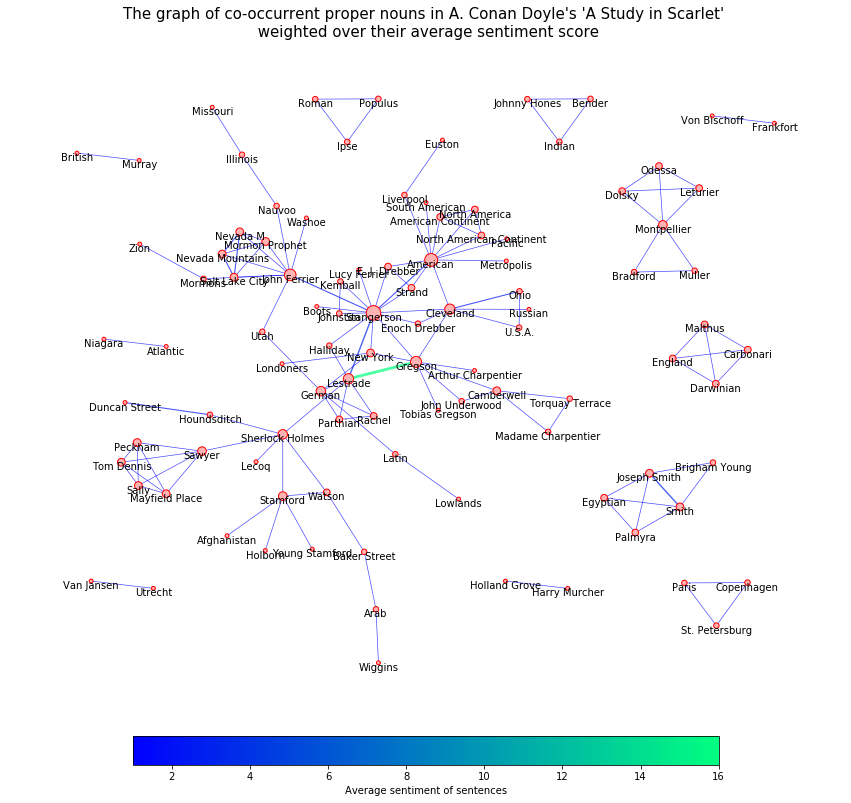

In [34]:
edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.winter #cool
weight_list = [ e[2]['weight'] for e in Gw.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[15*Gw.degree(n) for n in Gw.nodes()]

figsize=(15,15)

pos=graphviz_layout(Gw) 
# pos=nx.spring_layout(Gw)

node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gw, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gw, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.7)
plt.axis('off');
yoffset = {}
y_off = -7 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gw, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The graph of co-occurrent proper nouns in %s \n weighted over their average sentiment score" %titlename
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

#### Computation of all centrality measures

In [0]:
def draw_centralities_subplots(G,pos,withLabels=True,labfs=10,valpha=0.4,ealpha=0.4,figsi=(20,20),vals=False):
    centList=['degree_centrality','closeness_centrality','betweenness_centrality',
    'eigenvector_centrality','katz_centrality','page_rank']
    cenLen=len(centList)
    valus={}
    plt.figure(figsize=figsi)
    for uu,centr in enumerate(centList):
        if centr=='degree_centrality':
            cent=nx.degree_centrality(G)
            sstt='Degree Centralities'
            ssttt='degree centrality'
            valus[centr]=cent
        elif centr=='closeness_centrality':
            cent=nx.closeness_centrality(G)
            sstt='Closeness Centralities'
            ssttt='closeness centrality'
            valus[centr]=cent

        elif centr=='betweenness_centrality':
            cent=nx.betweenness_centrality(G)
            sstt='Betweenness Centralities'
            ssttt='betweenness centrality'
            valus[centr]=cent

        elif centr=='eigenvector_centrality':
            try:
                cent=nx.eigenvector_centrality(G,max_iter=2000)
                sstt='Eigenvector Centralities'
                ssttt='eigenvector centrality'
                valus[centr]=cent

            except:
                valus[centr]=None

                continue
        elif centr=='katz_centrality':
            phi = (1+math.sqrt(5))/2.0 # largest eigenvalue of adj matrix
            cent=nx.katz_centrality_numpy(G,1/phi-0.01)
            sstt='Katz Centralities'
            ssttt='Katz centrality'
            valus[centr]=cent

        elif centr=='page_rank':
            try:
                cent=nx.pagerank(G)
                sstt='PageRank'
                ssttt='pagerank'
                valus[centr]=cent

            except:
                valus[centr]=None

                continue
        cs={}
        for k,v in cent.items():
            if v not in cs:
                cs[v]=[k]
            else:
                cs[v].append(k)
        nodrank=[]
        uui=0
        for k in sorted(cs,reverse=True):
            for v in cs[k]:
                if uui<5:
                    nodrank.append(v)
                    uui+=1
        nodeclo=[]
        for k,v in cent.items():
            if k in  nodrank :
                nodeclo.append(v)
            else:
                nodeclo.append(0.)
        plt.subplot(1+cenLen/2.,2,uu+1).set_title(sstt)
        if withLabels:
            labe=nx.draw_networkx_labels(G,pos=pos,font_size=labfs)
        nx.draw_networkx_nodes(G,pos=pos,nodelist=cent.keys(),
                               node_color=nodeclo,
                               cmap=plt.cm.Reds,alpha=valpha)
        nx.draw_networkx_edges(G,pos=pos,edge_color='b', alpha=ealpha)
        plt.title(sstt,fontsize=20)
        kk=plt.axis('off')
    if vals:
        return valus

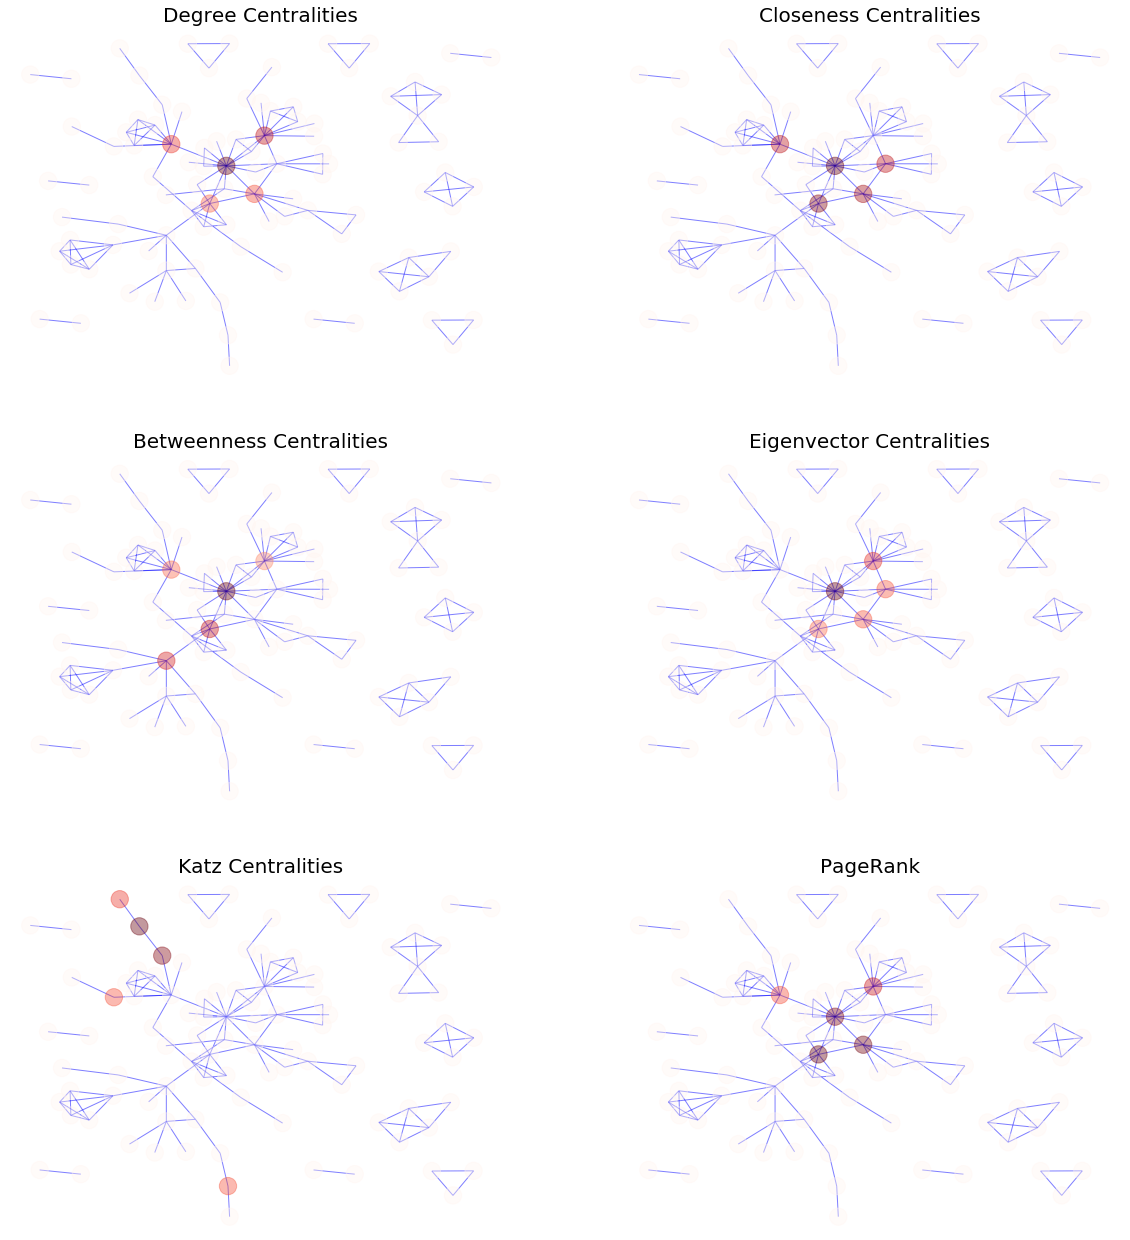

In [36]:
centrali1=draw_centralities_subplots(Gw,pos,withLabels=False,labfs=5,figsi=(20,30),ealpha=.5,vals=True)

In [37]:
# The table of centralities of common phrases in the graph of A Study In Scarlet

dfcent1=pd.DataFrame()
dfcent1.insert(0,'Common Nouns',centrali1[list(centrali1.keys())[0]].keys())
u=1
for i,k in centrali1.items():
    dfcent1.insert(u,i,k.values())
dfcent1.sort_values('degree_centrality',ascending=False).head(10)

Common Nouns  page_rank  ...  closeness_centrality  degree_centrality
28       Stangerson   0.040367  ...              0.273569           0.141414
27         American   0.032443  ...              0.215539           0.111111
55     John Ferrier   0.024517  ...              0.218855           0.090909
29          Gregson   0.041602  ...              0.238418           0.080808
9          Lestrade   0.042611  ...              0.255550           0.070707
23        Cleveland   0.019853  ...              0.216633           0.070707
5   Sherlock Holmes   0.018015  ...              0.214456           0.060606
31           German   0.014882  ...              0.205177           0.060606
11           Sawyer   0.012583  ...              0.167360           0.050505
17      Montpellier   0.016038  ...              0.050505           0.050505

[10 rows x 7 columns]

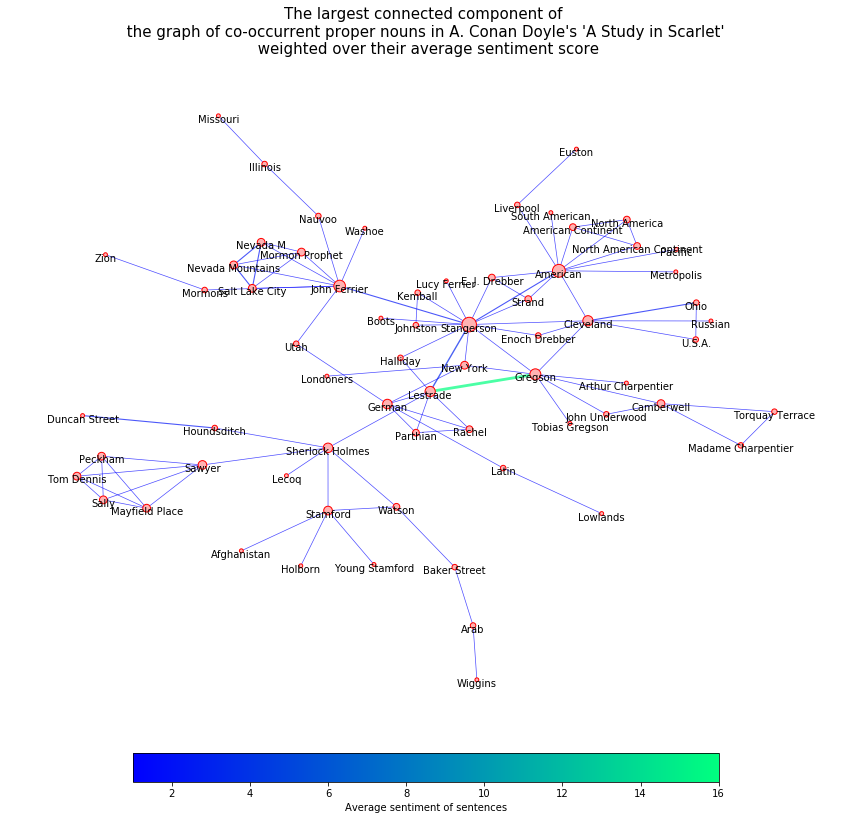

In [38]:
edge_width=[Gwlcc[u][v]['weight'] for u,v in Gwlcc.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.winter #cool
weight_list = [ e[2]['weight'] for e in Gwlcc.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[15*Gwlcc.degree(n) for n in Gwlcc.nodes()]

figsize=(15,15)
pos=graphviz_layout(Gwlcc) 
node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gwlcc, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gwlcc, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.7)
plt.axis('off');
yoffset = {}
y_off = -5 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gwlcc, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The largest connected component of \n the graph of co-occurrent proper nouns in %s \n weighted over their average sentiment score" %titlename
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

### 2. The Hound of the Baskervilles

In [0]:
text=text2
titlename=titlename2
names=names2

In [40]:
sorted(names)

['Alton',
 'American',
 'Anderson',
 'Anthony',
 'Antonio',
 'Baker Street',
 'Barrymore',
 'Baskervilles',
 'Belgian',
 'Beryl Garcia',
 'Black Tor',
 'Borough',
 'Bradley',
 'British',
 'Bushman',
 'Canada',
 'Cartwright',
 'Carére',
 'Celtic',
 'Charles Baskerville',
 'Christian',
 'Clarendon',
 'Coombe Tracey',
 'Costa Rica',
 'Dartmoor',
 'Desmonds',
 'Devonshire',
 'Edison',
 'Elizabethan',
 'England',
 'Esquimau',
 'Europe',
 'Fernworthy',
 'Foulmire',
 'Frankland',
 'Fraser',
 'French',
 'George',
 'German',
 'Grimpen Mire',
 'Halloa',
 'Henry Baskerville',
 'Holmes',
 'Holy Writ',
 'Hugo Baskerville',
 'Jack',
 'James Desmond',
 'James Mortimer',
 'John Clayton',
 'John Morland',
 'Laura Lyons',
 'Lestrade',
 'Liberal',
 'Little Russia',
 'London',
 'Long Down',
 'Mangles',
 'Merripit House',
 'Meyers',
 'Middleton',
 'Miss Stapleton',
 'Montpensier',
 'Mr. Stapleton',
 'Mrs. Barrymore',
 'Murphy',
 'Newcastle',
 'North Carolina',
 'North Devon',
 'Notting',
 'Oldmore',
 'Oxfo

In [41]:
pre=[]
for i in range(len(names)):
    start=names[i][:4]
    pre.append(start)
for j,k in Counter(pre).items():
    if k>1:
        print(j)

Jame
John
Nort
Sout


In [0]:
alias_dict2={}
for n in names:
    if n=='English':
        alias_dict2[n]='England'
    elif n=='England':
        alias_dict2[n]='England'
    elif n=='Enoch Drebber':
        alias_dict2[n]='Enoch Drebber'
    elif n=='Enoch J. Drebber':
        alias_dict2[n]='Enoch Drebber'
    elif n=='South America':
        alias_dict2[n]='South America'
    elif n=='South American':
        alias_dict2[n]='South America'
    elif n=='Young Jefferson':
        alias_dict2[n]='Young Jefferson'
    elif n=='Young Jefferson Hope':
        alias_dict2[n]='Young Jefferson'
    elif n=="Beryl Stapleton":
        alias_dict2[n]="Miss Stapleton"
    elif n=="Holmes":
        alias_dict2[n]="Sherlock Holmes"
#     elif n=="King of the Winged Monkeys":
#         alias_dict[n]="Monkey King"
#     elif n=="Monkey King":
#         alias_dict[n]="Monkey King"
    else:
        alias_dict2[n]=n
# print("The dictionary of aliases has %i keys (names) and %i unique values (aliased proper nouns)" %(len(alias_dict.keys()),len(set(alias_dict.values()))))
# for k,v in alias_dict.items():
#     print(k,"-->",v)

#### Sentence tokenization & sentiment analysis

In [43]:
blob = TextBlob(text)
textSentences = blob.sentences
sendic=dict()
for i,v in enumerate(textSentences):
    sent=v.sentiment.polarity
    wl=[]
    for term in list(set(alias_dict2.values())):
        if term in v: 
            wl.append(term)
    if len(wl)>1:
        sendic[i]=wl 
medges=[]
for k,v in sendic.items():
    sent=textSentences[k].sentiment.polarity
    dd={}
    ps=set()
    for j in itertools.combinations(v, 2):
        ps.add(j)
        dd[j]=(k,sent)
    for jj in ps:
        s=0
        ss=0
        for kk,vv in dd.items():
            if kk==jj:
                s+=1
                ss+=vv[1]
        if alias_dict2[jj[0]]!=alias_dict2[jj[1]]:
            medges.append((alias_dict2[jj[0]],alias_dict2[jj[1]],titlename,"Sentence_"+str(k),ss/float(s)))
print("%s contains %i sentential co-occurrences among %i aliased proper nouns"%(titlename,len(medges),len(set(alias_dict2.values()))))
medges

A. Conan Doyle's 'The Hound of the Baskervilles' contains 113 sentential co-occurrences among 106 aliased proper nouns


[('James Mortimer',
  'Watson',
  "A. Conan Doyle's 'The Hound of the Baskervilles'",
  'Sentence_104',
  -0.07777777777777778),
 ('James Mortimer',
  'Baskervilles',
  "A. Conan Doyle's 'The Hound of the Baskervilles'",
  'Sentence_159',
  0.0),
 ('Devonshire',
  'Charles Baskerville',
  "A. Conan Doyle's 'The Hound of the Baskervilles'",
  'Sentence_170',
  -0.18333333333333335),
 ('Holy Writ',
  'Providence',
  "A. Conan Doyle's 'The Hound of the Baskervilles'",
  'Sentence_225',
  0.16666666666666666),
 ('Liberal',
  'Charles Baskerville',
  "A. Conan Doyle's 'The Hound of the Baskervilles'",
  'Sentence_239',
  -0.03333333333333333),
 ('Charles Baskerville',
  'Yew Alley',
  "A. Conan Doyle's 'The Hound of the Baskervilles'",
  'Sentence_254',
  0.17222222222222222),
 ('London',
  'Barrymore',
  "A. Conan Doyle's 'The Hound of the Baskervilles'",
  'Sentence_256',
  0.0),
 ('Henry Baskerville',
  'Charles Baskerville',
  "A. Conan Doyle's 'The Hound of the Baskervilles'",
  'Sente

In [44]:
medgesd=[]
for e in medges:
    d={}
    d['Novel']=e[2]
    d['Sentence']=e[3]
    d['Average sentiment']=e[4]
    medgesd.append((e[0],e[1],d))
    
# print(medgesd) 

G = nx.MultiGraph()
G.add_edges_from(medgesd)
for e in G.edges(data=True):
    if e[0]==e[1]:
        G.remove_edge(e[0],e[1])
# print(G.edges(data=True))
weight={(x,y):v for (x, y), v in Counter(G.edges()).items()}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
Gw = nx.Graph()
Gw.add_weighted_edges_from(w_edges)
# titlea={}
# for k in Gw.edges():
#     titlea[k]=titlename1
# nx.set_edge_attributes(Gw, 'Novel', titlea)
for e in Gw.edges():
    Gw[e[0]][e[1]]['Novel'] = titlename
# print(Gw.edges(data=True))
print("The graph of sententially co-occurrent proper nouns in %s is a weighted graph and it has %i nodes and %i edges \n" %(titlename,len(Gw.nodes()),len(Gw.edges())))
out=' '.join([n+"\n" for n in alias_dict2.values() if n not in Gw.nodes()])
print("The proper names which do not co-occur in sentences are: \n %s" %out)
# print "Graph Gw is a weighted graph with %i nodes and %i edges" %(len(Gw.nodes()),len(Gw.edges()))
print("The density of this graph is %.3f" %nx.density(Gw))
if nx.is_connected(Gw)==True:
    print ("This graph is a connected graph")
else:
    print ("This graph is a disconnected graph and it has",nx.number_connected_components(Gw),"connected components" )   
giant = max(connected_component_subgraphs(Gw), key=len)
Gwlcc=Gw.subgraph(giant)
print ("The largest connected component of this graph is a weighted graph with %i nodes and %i edges" %(len(Gwlcc.nodes()),len(Gwlcc.edges())))
print ("The density of the largest connected component of this graph is %.3f" %nx.density(Gwlcc))

The graph of sententially co-occurrent proper nouns in A. Conan Doyle's 'The Hound of the Baskervilles' is a weighted graph and it has 69 nodes and 94 edges 

The proper names which do not co-occur in sentences are: 
 Belgian
 Black Tor
 Bushman
 Carére
 Celtic
 Christian
 Clarendon
 Edison
 Elizabethan
 Europe
 Fernworthy
 Foulmire
 Fraser
 George
 German
 Grimpen Mire
 Hugo Baskerville
 Jack
 John Morland
 Long Down
 Middleton
 Montpensier
 Murphy
 North Devon
 Paddington
 Penang
 Plymouth
 Reynolds
 Rodney
 South African
 Southampton
 Spartan
 Stamford
 Strand
 Uncle
 Vixen Tor
 Young Baskerville

The density of this graph is 0.040
This graph is a disconnected graph and it has 10 connected components
The largest connected component of this graph is a weighted graph with 47 nodes and 77 edges
The density of the largest connected component of this graph is 0.071


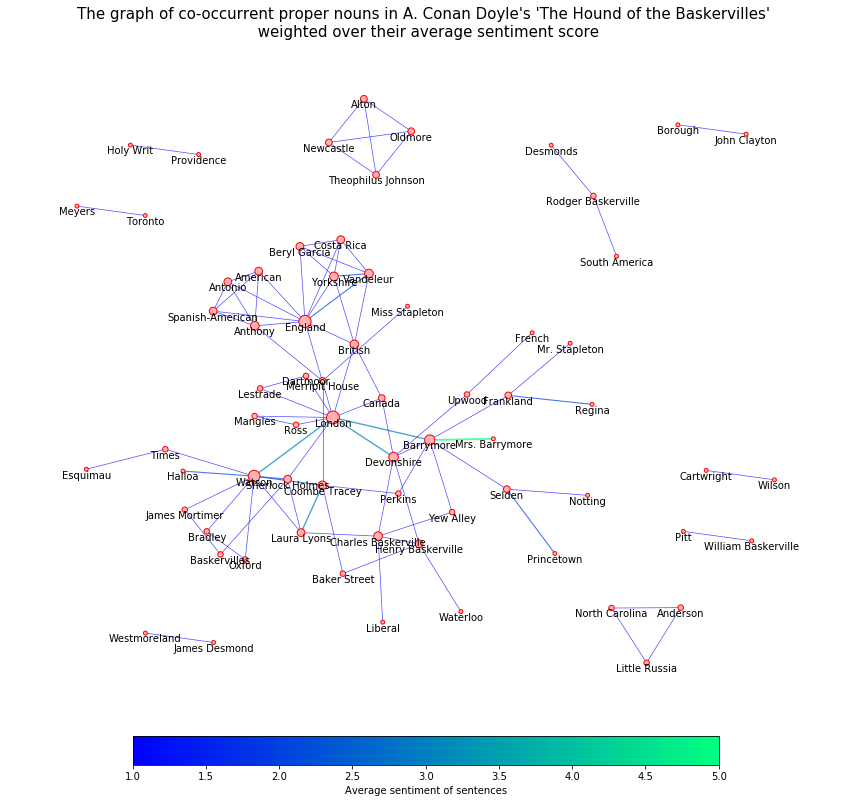

In [45]:
edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.winter #cool
weight_list = [ e[2]['weight'] for e in Gw.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[15*Gw.degree(n) for n in Gw.nodes()]

figsize=(15,15)

pos=graphviz_layout(Gw) 
# pos=nx.spring_layout(Gw)

node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gw, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gw, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.7)
plt.axis('off');
yoffset = {}
y_off = -7 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gw, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The graph of co-occurrent proper nouns in %s \n weighted over their average sentiment score" %titlename
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

#### Computation of all centrality measures

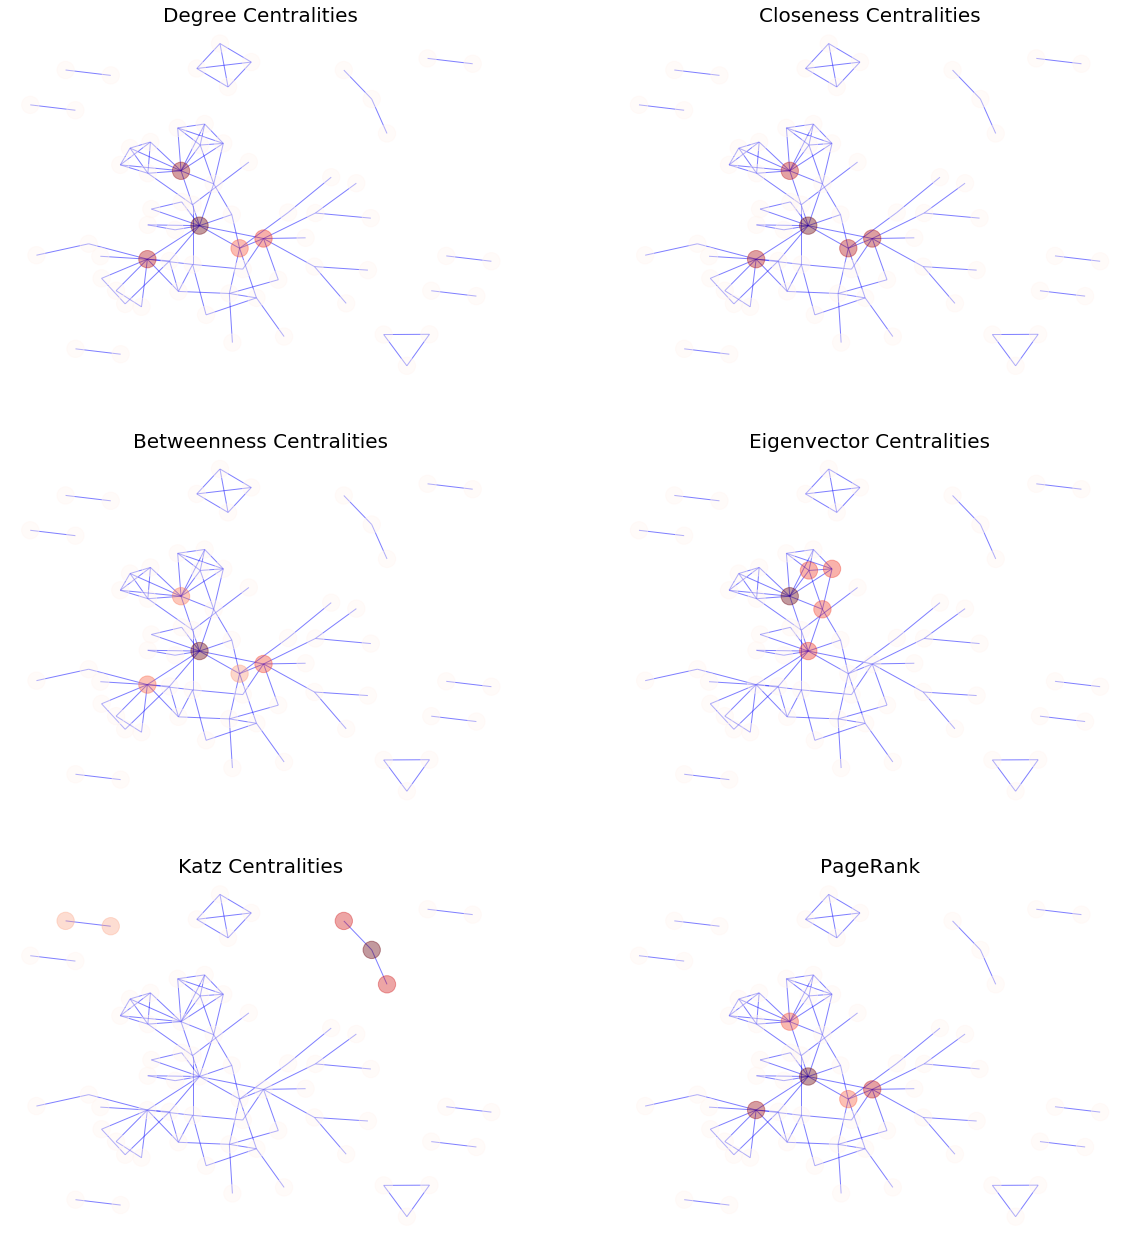

In [46]:
centrali2=draw_centralities_subplots(Gw,pos,withLabels=False,labfs=5,figsi=(20,30),ealpha=.5,vals=True)

In [47]:
# The table of centralities of common phrases in the graph of The Hound of the Baskervilles

dfcent2=pd.DataFrame()
dfcent2.insert(0,'Common Nouns',centrali2[list(centrali2.keys())[0]].keys())
u=1
for i,k in centrali2.items():
    dfcent2.insert(u,i,k.values())

dfcent2.sort_values('degree_centrality',ascending=False).head(10)

Common Nouns  page_rank  ...  closeness_centrality  degree_centrality
9                London   0.051735  ...              0.334598           0.161765
26              England   0.029700  ...              0.265963           0.147059
1                Watson   0.046403  ...              0.280339           0.132353
13            Barrymore   0.040529  ...              0.285483           0.102941
11           Devonshire   0.026945  ...              0.277836           0.088235
12  Charles Baskerville   0.019560  ...              0.233967           0.073529
36            Vandeleur   0.018770  ...              0.198202           0.073529
37            Yorkshire   0.016390  ...              0.198202           0.073529
25              British   0.014516  ...              0.250949           0.073529
6         Coombe Tracey   0.026661  ...              0.245021           0.073529

[10 rows x 7 columns]

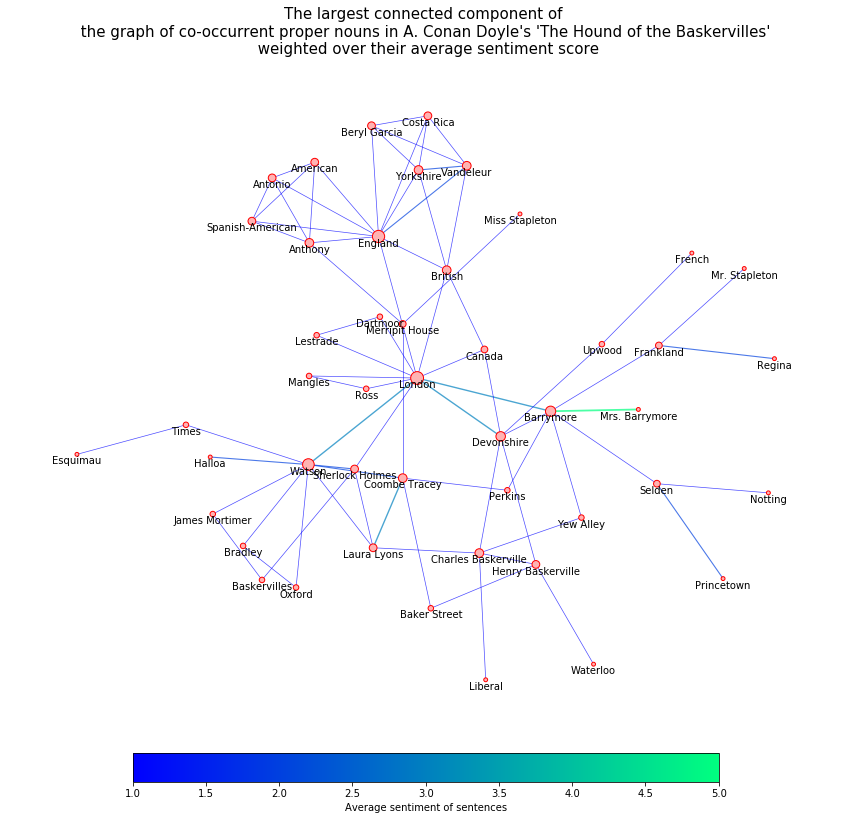

In [48]:
edge_width=[Gwlcc[u][v]['weight'] for u,v in Gwlcc.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.winter #cool
weight_list = [ e[2]['weight'] for e in Gwlcc.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[15*Gwlcc.degree(n) for n in Gwlcc.nodes()]

figsize=(15,15)
pos=graphviz_layout(Gwlcc) 
node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gwlcc, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gwlcc, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.7)
plt.axis('off');
yoffset = {}
y_off = -5 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gwlcc, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The largest connected component of \n the graph of co-occurrent proper nouns in %s \n weighted over their average sentiment score" %titlename
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

### 3. The Valley of Fear

In [0]:
text=text3
titlename=titlename3
names=names3

In [50]:
sorted(names)

['Aberdonian',
 'Allen',
 'American',
 'Ames',
 'Andrew Rae',
 'Andrews',
 'Archie Swindon',
 'Arthur Willaby',
 'Atwood',
 'Baker Street',
 'Baldwin',
 'Bartholomew',
 'Bartholomew Wilson',
 'Benito Canyon',
 'Billy',
 'Birdy Edwards',
 'Birlstone Manor House',
 'Boarder',
 'Bodymaster',
 'Bradshaw',
 'Brethren',
 'British',
 'Californian',
 'Cape Town',
 'Capus',
 'Carter',
 'Catholic',
 'Cecil Barker',
 'Cecil James Barker',
 'Charles Chandos',
 'Charlie Williams',
 'Chester Wilcox',
 'Chicago',
 'Chinese',
 'Crabbe',
 'Danton',
 'Detroit',
 'Douglas',
 'East Ham',
 'Egan',
 'English',
 'Ettie Edwards',
 'Ettie Shafter',
 'Europe',
 'Evans Pott',
 'Foreman Blaker',
 'Fred',
 'Freeman',
 'Freemen',
 'French',
 'George',
 'Germany',
 'Gilmerton',
 'Gower',
 'Greek',
 'Hampstead',
 'Hargrave',
 'Harraway',
 'Helmdale',
 'Herman Strauss',
 "Hobson's Patch",
 'Holmes',
 'Hudson',
 'Hyam',
 'India',
 'Inner Deacon',
 'Irishman',
 'Ironhill',
 'Italian',
 'Jack Knox',
 'Jacob Shafter',
 'J

In [51]:
pre=[]
for i in range(len(names)):
    start=names[i][:4]
    pre.append(start)
for j,k in Counter(pre).items():
    if k>1:
        print(j)

Andr
Bart
Ceci
Char
Etti
Free
Jaco
Jame
Jona
New 
Scot
Sout
Verm


In [0]:
alias_dict3={}
for n in names:
    if n=='Aberdeen':
        alias_dict3[n]='Aberdeen'
    elif n=='Aberdonian':
        alias_dict3[n]='Aberdeen'
    elif n=='Cecil James Barker':
        alias_dict3[n]='Cecil Barker'
    elif n=='Cecil Barker':
        alias_dict3[n]='Cecil Barker'
    elif n=='Bodymaster':
        alias_dict3[n]='McGinty'
    elif n=='John Douglas':
        alias_dict3[n]='Douglas'
    elif n=='Jack McMurdo':
        alias_dict3[n]='Douglas'
    elif n=='Birdy Edwards':
        alias_dict3[n]='Douglas'
    elif n=="Holmes":
        alias_dict3[n]="Sherlock Holmes"
    elif n=="Sherlock Holmes—":
        alias_dict3[n]="Sherlock Holmes"
#     elif n=="King of the Winged Monkeys":
#         alias_dict[n]="Monkey King"
#     elif n=="Monkey King":
#         alias_dict[n]="Monkey King"
    else:
        alias_dict3[n]=n
# print("The dictionary of aliases has %i keys (names) and %i unique values (aliased proper nouns)" %(len(alias_dict.keys()),len(set(alias_dict.values()))))
# for k,v in alias_dict.items():
#     print(k,"-->",v)

#### Sentence tokenization & sentiment analysis

In [53]:
blob = TextBlob(text)
textSentences = blob.sentences
sendic=dict()
for i,v in enumerate(textSentences):
    sent=v.sentiment.polarity
    wl=[]
    for term in list(set(alias_dict3.values())):
        if term in v: 
            wl.append(term)
    if len(wl)>1:
        sendic[i]=wl 
medges=[]
for k,v in sendic.items():
    sent=textSentences[k].sentiment.polarity
    dd={}
    ps=set()
    for j in itertools.combinations(v, 2):
        ps.add(j)
        dd[j]=(k,sent)
    for jj in ps:
        s=0
        ss=0
        for kk,vv in dd.items():
            if kk==jj:
                s+=1
                ss+=vv[1]
        if alias_dict3[jj[0]]!=alias_dict3[jj[1]]:
            medges.append((alias_dict3[jj[0]],alias_dict3[jj[1]],titlename,"Sentence_"+str(k),ss/float(s)))
print("%s contains %i sentential co-occurrences among %i aliased proper nouns"%(titlename,len(medges),len(set(alias_dict3.values()))))
medges

A. Conan Doyle's 'The Valley of Fear' contains 173 sentential co-occurrences among 151 aliased proper nouns


[('Porlock',
  'Watson',
  "A. Conan Doyle's 'The Valley of Fear'",
  'Sentence_14',
  -0.45),
 ('British',
  'India',
  "A. Conan Doyle's 'The Valley of Fear'",
  'Sentence_171',
  0.0),
 ('Billy',
  'MacDonald',
  "A. Conan Doyle's 'The Valley of Fear'",
  'Sentence_214',
  0.15),
 ('Europe',
  'MacDonald',
  "A. Conan Doyle's 'The Valley of Fear'",
  'Sentence_221',
  0.012499999999999997),
 ('Birlstone Manor House',
  'Douglas',
  "A. Conan Doyle's 'The Valley of Fear'",
  'Sentence_241',
  -0.5),
 ('French',
  'Jean Baptiste Greuze',
  "A. Conan Doyle's 'The Valley of Fear'",
  'Sentence_319',
  0.0),
 ('Jonathan Wild',
  'London',
  "A. Conan Doyle's 'The Valley of Fear'",
  'Sentence_386',
  -0.033333333333333326),
 ('White Mason',
  'MacDonald',
  "A. Conan Doyle's 'The Valley of Fear'",
  'Sentence_450',
  0.05),
 ('English',
  'London',
  "A. Conan Doyle's 'The Valley of Fear'",
  'Sentence_509',
  0.0),
 ('Douglas',
  'London',
  "A. Conan Doyle's 'The Valley of Fear'",
  'S

In [54]:
medgesd=[]
for e in medges:
    d={}
    d['Novel']=e[2]
    d['Sentence']=e[3]
    d['Average sentiment']=e[4]
    medgesd.append((e[0],e[1],d))
    
# print(medgesd) 

G = nx.MultiGraph()
G.add_edges_from(medgesd)
for e in G.edges(data=True):
    if e[0]==e[1]:
        G.remove_edge(e[0],e[1])
# print(G.edges(data=True))
weight={(x,y):v for (x, y), v in Counter(G.edges()).items()}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
Gw = nx.Graph()
Gw.add_weighted_edges_from(w_edges)
# titlea={}
# for k in Gw.edges():
#     titlea[k]=titlename1
# nx.set_edge_attributes(Gw, 'Novel', titlea)
for e in Gw.edges():
    Gw[e[0]][e[1]]['Novel'] = titlename
# print(Gw.edges(data=True))
print("The graph of sententially co-occurrent proper nouns in %s is a weighted graph and it has %i nodes and %i edges \n" %(titlename,len(Gw.nodes()),len(Gw.edges())))
out=' '.join([n+"\n" for n in alias_dict3.values() if n not in Gw.nodes()])
print("The proper names which do not co-occur in sentences are: \n %s" %out)
# print "Graph Gw is a weighted graph with %i nodes and %i edges" %(len(Gw.nodes()),len(Gw.edges()))
print("The density of this graph is %.3f" %nx.density(Gw))
if nx.is_connected(Gw)==True:
    print ("This graph is a connected graph")
else:
    print ("This graph is a disconnected graph and it has",nx.number_connected_components(Gw),"connected components" )   
giant = max(connected_component_subgraphs(Gw), key=len)
Gwlcc=Gw.subgraph(giant)
print ("The largest connected component of this graph is a weighted graph with %i nodes and %i edges" %(len(Gwlcc.nodes()),len(Gwlcc.edges())))
print ("The density of the largest connected component of this graph is %.3f" %nx.density(Gwlcc))

The graph of sententially co-occurrent proper nouns in A. Conan Doyle's 'The Valley of Fear' is a weighted graph and it has 99 nodes and 118 edges 

The proper names which do not co-occur in sentences are: 
 Aberdeen
 Andrew Rae
 Archie Swindon
 Arthur Willaby
 Baker Street
 Boarder
 Bradshaw
 Cape Town
 Capus
 Catholic
 Charles Chandos
 Chester Wilcox
 Chinese
 Egan
 Ettie Shafter
 Foreman Blaker
 Fred
 George
 Germany
 Greek
 Hampstead
 Helmdale
 Herman Strauss
 Hudson
 Irishman
 Italian
 James H. Scott
 James Stanger
 Jim Carnaway
 Jonas Pinto
 Kent
 Mahratta
 May.
 Mike Scanlan
 Moriarty
 Portalis
 Russia
 Scott
 Shafters
 Smith
 Solomon
 Standback
 Sulky
 Tis
 Treasurer Higgins
 Uncle Sam
 United States
 Vell
 Vermissa Herald
 Victoria
 Washington
 Wood

The density of this graph is 0.024
This graph is a disconnected graph and it has 17 connected components
The largest connected component of this graph is a weighted graph with 34 nodes and 48 edges
The density of the largest conne

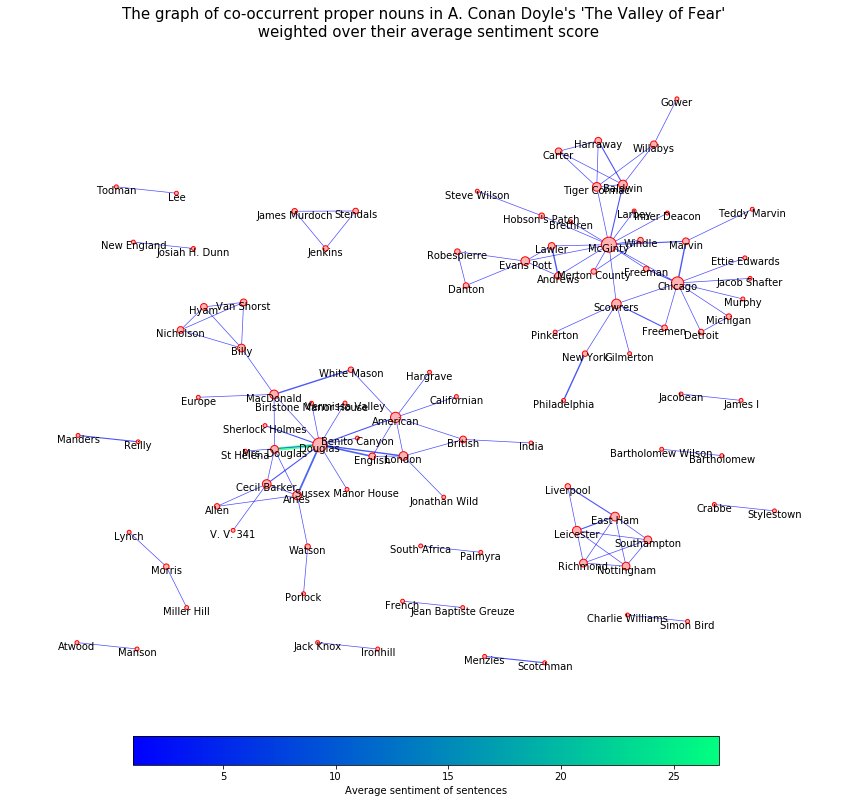

In [55]:
edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.winter #cool
weight_list = [ e[2]['weight'] for e in Gw.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[15*Gw.degree(n) for n in Gw.nodes()]

figsize=(15,15)

pos=graphviz_layout(Gw) 
# pos=nx.spring_layout(Gw)

node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gw, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gw, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.7)
plt.axis('off');
yoffset = {}
y_off = -7 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gw, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The graph of co-occurrent proper nouns in %s \n weighted over their average sentiment score" %titlename
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

#### Computation of all centrality measures

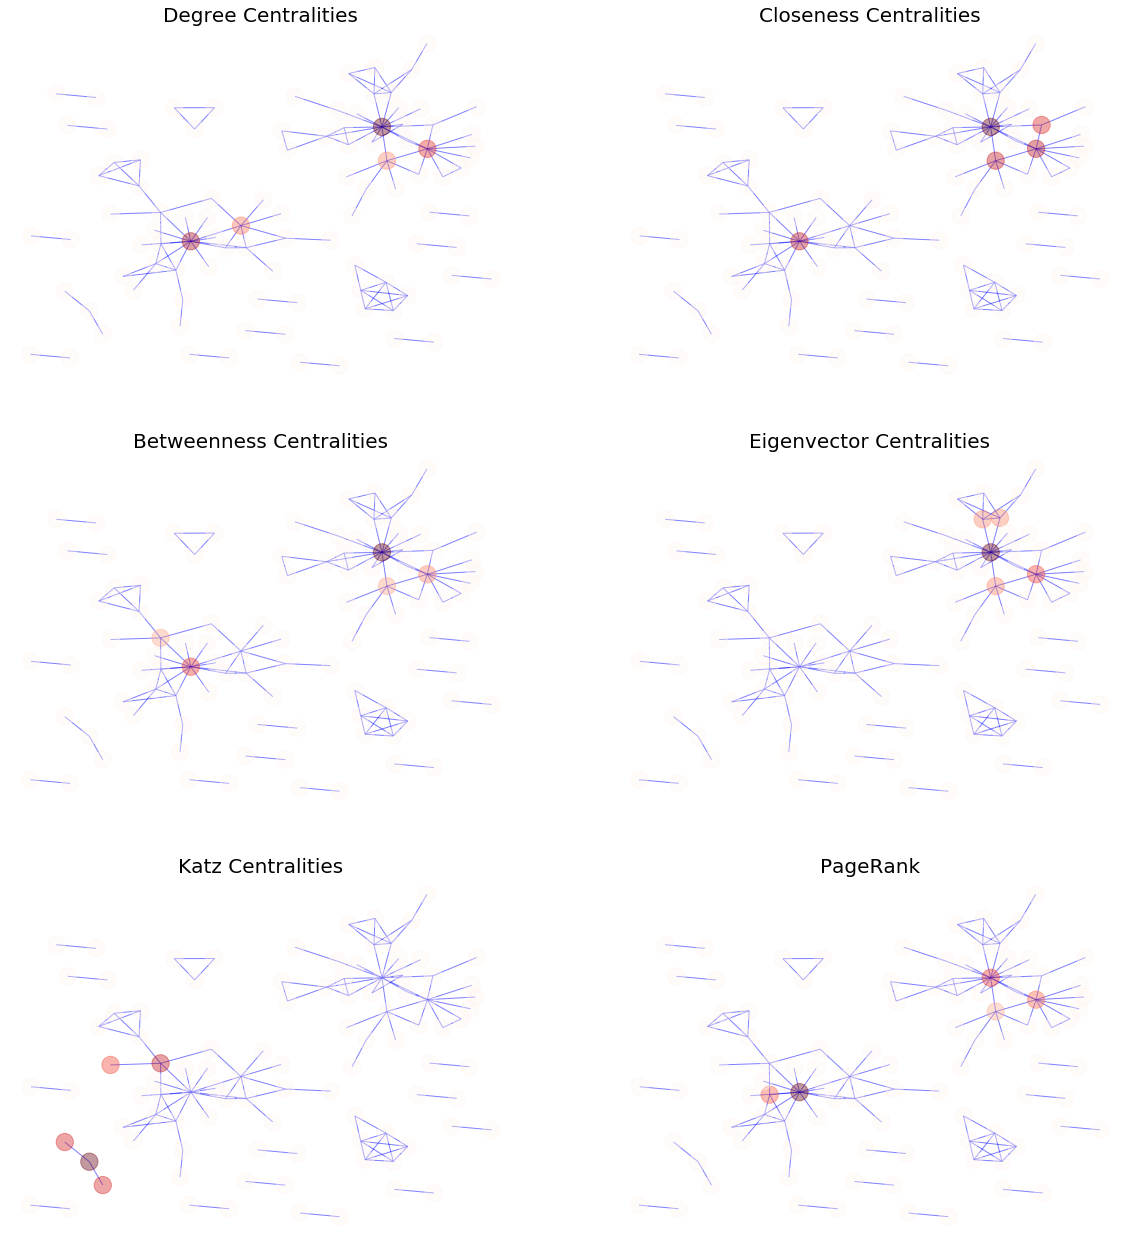

In [56]:
centrali3=draw_centralities_subplots(Gw,pos,withLabels=False,labfs=5,figsi=(20,30),ealpha=.5,vals=True)

In [57]:
# The table of centralities of common phrases in the graph of The Valley of Fear

dfcent3=pd.DataFrame()
dfcent3.insert(0,'Common Nouns',centrali3[list(centrali3.keys())[0]].keys())
u=1
for i,k in centrali3.items():
    dfcent3.insert(u,i,k.values())
dfcent3.sort_values('degree_centrality',ascending=False).head(10)

Common Nouns  page_rank  ...  closeness_centrality  degree_centrality
42       McGinty   0.044870  ...              0.209665           0.153061
14       Douglas   0.070665  ...              0.166667           0.132653
40       Chicago   0.036071  ...              0.170958           0.102041
5       American   0.016436  ...              0.129032           0.071429
39      Scowrers   0.020326  ...              0.161047           0.061224
35     Leicester   0.012638  ...              0.051020           0.051020
63  Tiger Cormac   0.013004  ...              0.146214           0.051020
34      East Ham   0.014612  ...              0.051020           0.051020
18  Cecil Barker   0.010805  ...              0.119403           0.051020
53       Baldwin   0.017511  ...              0.146214           0.051020

[10 rows x 7 columns]

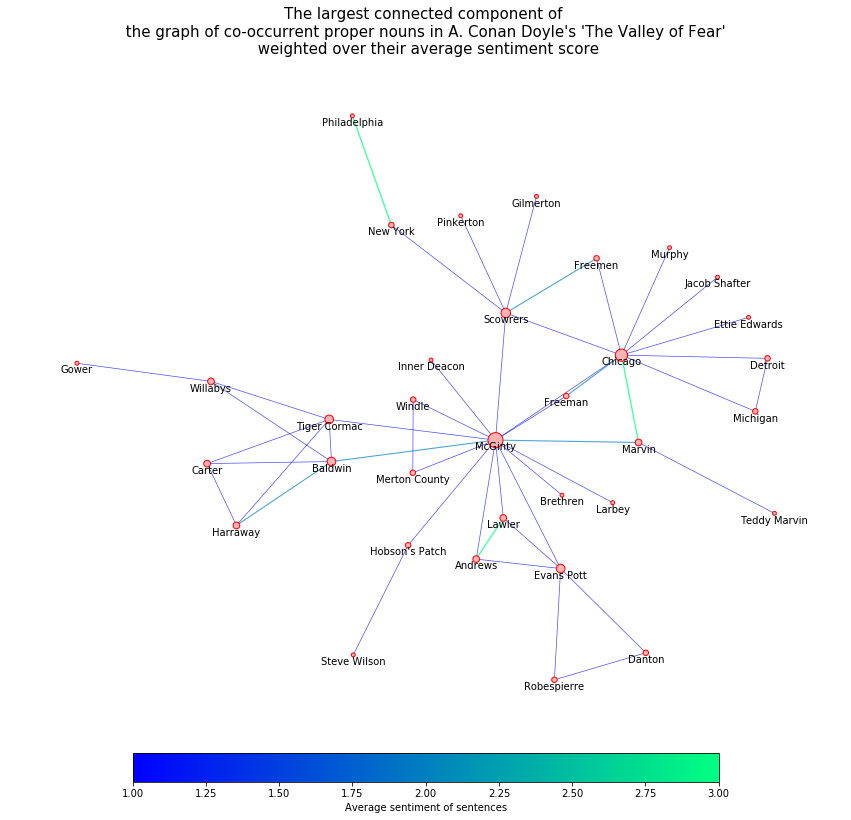

In [58]:
edge_width=[Gwlcc[u][v]['weight'] for u,v in Gwlcc.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.winter #cool
weight_list = [ e[2]['weight'] for e in Gwlcc.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[15*Gwlcc.degree(n) for n in Gwlcc.nodes()]

figsize=(15,15)
pos=graphviz_layout(Gwlcc) 
node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gwlcc, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gwlcc, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.7)
plt.axis('off');
yoffset = {}
y_off = -5 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gwlcc, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The largest connected component of \n the graph of co-occurrent proper nouns in %s \n weighted over their average sentiment score" %titlename
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

### 4. The Sign of the Four

In [0]:
text=text4
titlename=titlename4
names=names4

In [60]:
sorted(names)

['Abdullah Khan',
 'Abel White',
 'Achillis',
 'Achmet',
 'Afghanistan',
 'Africa',
 'Agra',
 'Alison',
 'American',
 'Andaman Island',
 'Andamans',
 'Arab',
 'Arthur Morstan',
 'Astrakhan',
 'Athelney Jones',
 'Baker Street',
 'Ballarat',
 'Barking Level',
 'Bartholomew',
 'Beaune',
 'Bengal',
 'Bernstone',
 'Blair Island',
 'Blondin',
 'Bouguereau',
 'Brazil',
 'British',
 'Brixton',
 'Broderick',
 'Bromley Brown',
 'Buddha',
 'Bunsen',
 'Calcutta',
 'Camberwell',
 'Captain Morstan',
 'Carlyle',
 'Cawnpore',
 'Cecil Forrester',
 'Celtic',
 'Chilian',
 'Cold Harbor Lane',
 'Colin',
 'Dartmoor',
 'Dawson',
 'Delhi',
 'Dost Akbar',
 'Edinburgh',
 'England',
 'Englishman',
 'Ere',
 'European',
 'Feringhee',
 'François Le Villard',
 'Frenchman',
 'Ganges',
 'Gravesend',
 'Greathed',
 'Greek',
 'Greenwich',
 'Gregson',
 'Hindoos',
 'Hippocratic',
 'Holmes',
 'Hudson',
 'I. A',
 'I. The',
 'Indian',
 'Jack',
 'Jean Paul',
 'Jiddah',
 'Jim',
 'John Sholto',
 'Jonathan Small',
 'Kennington La

In [61]:
pre=[]
for i in range(len(names)):
    start=names[i][:4]
    pre.append(start)
for j,k in Counter(pre).items():
    if k>1:
        print(j)

Anda
Engl
Gree
Lal 
Sher
Smit
Sout
Uppe


In [0]:
alias_dict4={}
for n in names:
    if n=='Englishman':
        alias_dict4[n]='England'
    elif n=='England':
        alias_dict4[n]='England'
    elif n=='Andaman Island':
        alias_dict4[n]='Andamans'
    elif n=='Andamans':
        alias_dict4[n]='Andamans'
    elif n=='Buddha':
        alias_dict4[n]='Buddhism'
    elif n=='Buddhism':
        alias_dict4[n]='Buddhism'
    elif n=='Smiths':
        alias_dict4[n]='Mordecai Smith'
    # elif n=='Smith':
        # alias_dict4[n]='Smith'
    elif n=="Holmes":
        alias_dict4[n]="Sherlock Holmes"
    # elif n=="Bartholomew":
        # alias_dict4[n]="Bartholomew Sholto"
    # elif n=="Thaddeus":
        # alias_dict4[n]="Thaddeus Sholto"
    elif n=="Mr. Sholto":
        alias_dict4[n]="John Sholto"
    elif n=="Major Sholto":
        alias_dict4[n]="John Sholto"
    elif n=="Smith":
        alias_dict4[n]="Mordecai Smith"
    elif n=='Mr. Smith':
        alias_dict4[n]='Mordecai Smith'
    else:
        alias_dict4[n]=n
# print("The dictionary of aliases has %i keys (names) and %i unique values (aliased proper nouns)" %(len(alias_dict.keys()),len(set(alias_dict.values()))))
# for k,v in alias_dict.items():
#     print(k,"-->",v)

#### Sentence tokenization & sentiment analysis

In [63]:
blob = TextBlob(text)
textSentences = blob.sentences
sendic=dict()
for i,v in enumerate(textSentences):
    sent=v.sentiment.polarity
    wl=[]
    for term in list(set(alias_dict4.values())):
        if term in v: 
            wl.append(term)
    if len(wl)>1:
        sendic[i]=wl 
medges=[]
for k,v in sendic.items():
    sent=textSentences[k].sentiment.polarity
    dd={}
    ps=set()
    for j in itertools.combinations(v, 2):
        ps.add(j)
        dd[j]=(k,sent)
    for jj in ps:
        s=0
        ss=0
        for kk,vv in dd.items():
            if kk==jj:
                s+=1
                ss+=vv[1]
        if alias_dict4[jj[0]]!=alias_dict4[jj[1]]:
            medges.append((alias_dict4[jj[0]],alias_dict4[jj[1]],titlename,"Sentence_"+str(k),ss/float(s)))
print("%s contains %i sentential co-occurrences among %i aliased proper nouns"%(titlename,len(medges),len(set(alias_dict4.values()))))
medges

A. Conan Doyle's 'The Sign of the Four' contains 122 sentential co-occurrences among 138 aliased proper nouns


[('Lestrade',
  'Athelney Jones',
  "A. Conan Doyle's 'The Sign of the Four'",
  'Sentence_33',
  0.15),
 ('Lestrade',
  'Gregson',
  "A. Conan Doyle's 'The Sign of the Four'",
  'Sentence_33',
  0.15),
 ('Athelney Jones',
  'Gregson',
  "A. Conan Doyle's 'The Sign of the Four'",
  'Sentence_33',
  0.15),
 ('Riga',
  'St. Louis',
  "A. Conan Doyle's 'The Sign of the Four'",
  'Sentence_55',
  0.18125),
 ('Langham',
  'Captain Morstan',
  "A. Conan Doyle's 'The Sign of the Four'",
  'Sentence_184',
  0.0),
 ('Mahomet Singh',
  'Dost Akbar',
  "A. Conan Doyle's 'The Sign of the Four'",
  'Sentence_318',
  -0.12666666666666668),
 ('Mahomet Singh',
  'Abdullah Khan',
  "A. Conan Doyle's 'The Sign of the Four'",
  'Sentence_318',
  -0.12666666666666668),
 ('Mahomet Singh',
  'Jonathan Small',
  "A. Conan Doyle's 'The Sign of the Four'",
  'Sentence_318',
  -0.12666666666666668),
 ('Jonathan Small',
  'Abdullah Khan',
  "A. Conan Doyle's 'The Sign of the Four'",
  'Sentence_318',
  -0.126666

In [64]:
medgesd=[]
for e in medges:
    d={}
    d['Novel']=e[2]
    d['Sentence']=e[3]
    d['Average sentiment']=e[4]
    medgesd.append((e[0],e[1],d))
    
# print(medgesd) 

G = nx.MultiGraph()
G.add_edges_from(medgesd)
for e in G.edges(data=True):
    if e[0]==e[1]:
        G.remove_edge(e[0],e[1])
# print(G.edges(data=True))
weight={(x,y):v for (x, y), v in Counter(G.edges()).items()}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
Gw = nx.Graph()
Gw.add_weighted_edges_from(w_edges)
# titlea={}
# for k in Gw.edges():
#     titlea[k]=titlename1
# nx.set_edge_attributes(Gw, 'Novel', titlea)
for e in Gw.edges():
    Gw[e[0]][e[1]]['Novel'] = titlename
# print(Gw.edges(data=True))
print("The graph of sententially co-occurrent proper nouns in %s is a weighted graph and it has %i nodes and %i edges \n" %(titlename,len(Gw.nodes()),len(Gw.edges())))
out=' '.join([n+"\n" for n in alias_dict4.values() if n not in Gw.nodes()])
print("The proper names which do not co-occur in sentences are: \n %s" %out)
# print "Graph Gw is a weighted graph with %i nodes and %i edges" %(len(Gw.nodes()),len(Gw.edges()))
print("The density of this graph is %.3f" %nx.density(Gw))
if nx.is_connected(Gw)==True:
    print ("This graph is a connected graph")
else:
    print ("This graph is a disconnected graph and it has",nx.number_connected_components(Gw),"connected components" )   
giant = max(connected_component_subgraphs(Gw), key=len)
Gwlcc=Gw.subgraph(giant)
print ("The largest connected component of this graph is a weighted graph with %i nodes and %i edges" %(len(Gwlcc.nodes()),len(Gwlcc.edges())))
print ("The density of the largest connected component of this graph is %.3f" %nx.density(Gwlcc))

The graph of sententially co-occurrent proper nouns in A. Conan Doyle's 'The Sign of the Four' is a weighted graph and it has 89 nodes and 108 edges 

The proper names which do not co-occur in sentences are: 
 Abel White
 Afghanistan
 Arthur Morstan
 Ballarat
 Barking Level
 Beaune
 British
 Buddhism
 Bunsen
 Carlyle
 Celtic
 Cold Harbor Lane
 Edinburgh
 François Le Villard
 Frenchman
 Ganges
 Greek
 Greenwich
 Hippocratic
 I. A
 I. The
 Jack
 Jean Paul
 Lambeth
 Mary Morstan
 Muttra
 Newfoundland
 Paris
 Poplar
 Richmond
 Rutland Island
 Sam Brown
 Senegambia
 Smalls
 Somerton
 South London
 Stern
 Tokay
 Tonga
 Trichinopoly
 Upper Norword
 Venetian
 Vincent Square
 Westminster
 Whimsical
 Wiggins
 Winwood Reade
 Wir
 Woolwich

The density of this graph is 0.028
This graph is a disconnected graph and it has 11 connected components
The largest connected component of this graph is a weighted graph with 52 nodes and 72 edges
The density of the largest connected component of this graph is

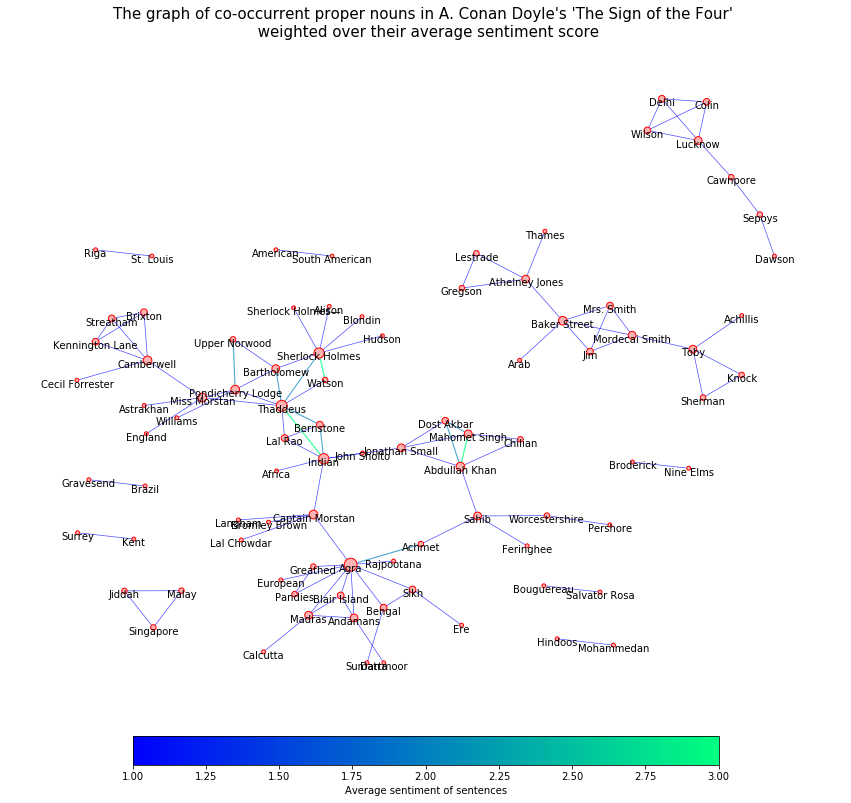

In [65]:
edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.winter #cool
weight_list = [ e[2]['weight'] for e in Gw.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[15*Gw.degree(n) for n in Gw.nodes()]

figsize=(15,15)

pos=graphviz_layout(Gw) 
# pos=nx.spring_layout(Gw)

node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gw, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gw, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.7)
plt.axis('off');
yoffset = {}
y_off = -7 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gw, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The graph of co-occurrent proper nouns in %s \n weighted over their average sentiment score" %titlename
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

#### Computation of all centrality measures

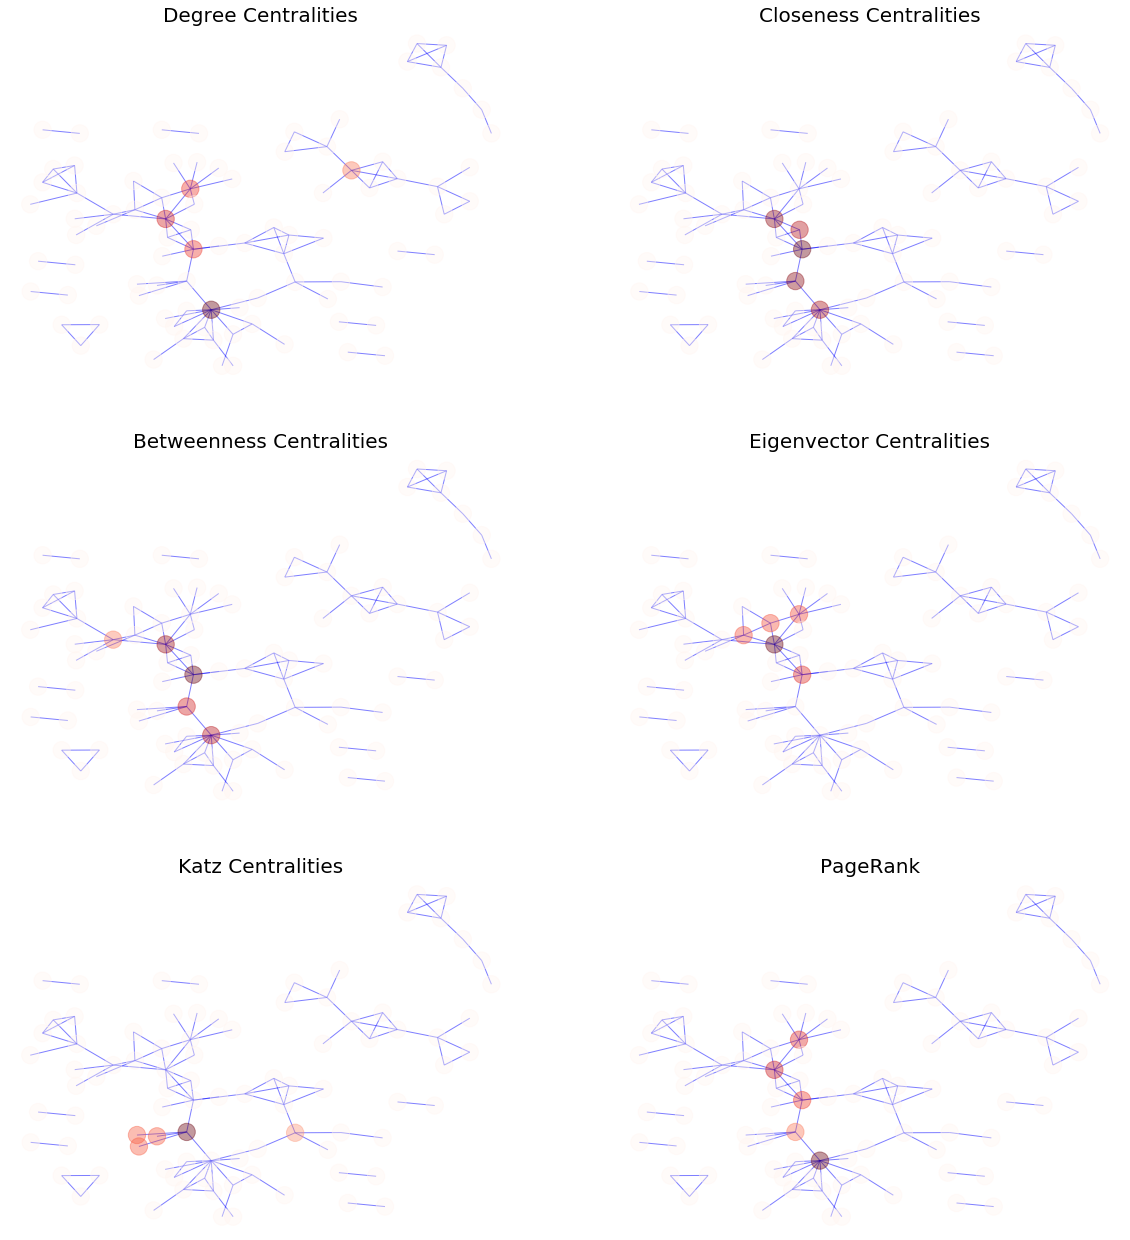

In [66]:
centrali4=draw_centralities_subplots(Gw,pos,withLabels=False,labfs=5,figsi=(20,30),ealpha=.5,vals=True)

In [67]:
# The table of centralities of common phrases in the graph of The Sign of the Four

dfcent4=pd.DataFrame()
dfcent4.insert(0,'Common Nouns',centrali4[list(centrali4.keys())[0]].keys())
u=1
for i,k in centrali4.items():
    dfcent4.insert(u,i,k.values())
dfcent4.sort_values('degree_centrality',ascending=False).head(10)

Common Nouns  page_rank  ...  closeness_centrality  degree_centrality
12               Agra   0.044080  ...              0.183583           0.125000
22           Thaddeus   0.033245  ...              0.195741           0.090909
19    Sherlock Holmes   0.030173  ...              0.155562           0.079545
10             Indian   0.027493  ...              0.212639           0.079545
15      Abdullah Khan   0.019904  ...              0.152355           0.056818
4        Baker Street   0.019379  ...              0.074380           0.056818
39         Camberwell   0.017944  ...              0.130782           0.056818
8     Captain Morstan   0.020199  ...              0.198368           0.056818
34  Pondicherry Lodge   0.017851  ...              0.157217           0.056818
36       Miss Morstan   0.017305  ...              0.160635           0.056818

[10 rows x 7 columns]

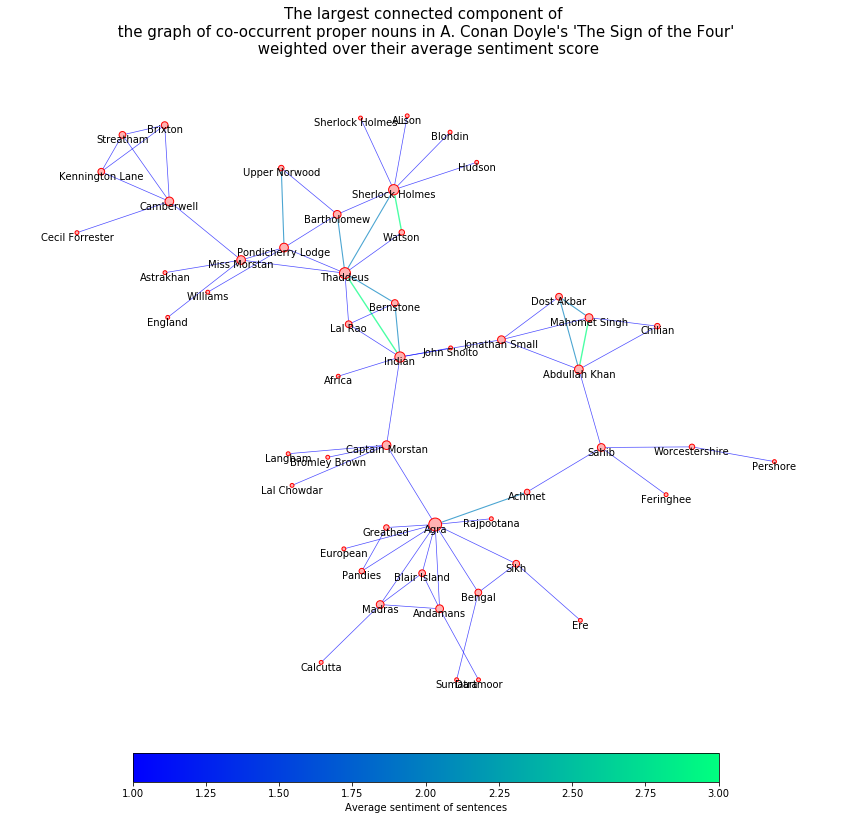

In [68]:
edge_width=[Gwlcc[u][v]['weight'] for u,v in Gwlcc.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.winter #cool
weight_list = [ e[2]['weight'] for e in Gwlcc.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[15*Gwlcc.degree(n) for n in Gwlcc.nodes()]

figsize=(15,15)
pos=graphviz_layout(Gwlcc) 
node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gwlcc, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gwlcc, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.7)
plt.axis('off');
yoffset = {}
y_off = -5 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gwlcc, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The largest connected component of \n the graph of co-occurrent proper nouns in %s \n weighted over their average sentiment score" %titlename
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

## The Network of Sententially Co-Occurring Proper Names of the Whole Corpora

In [0]:
texts=[text1,text2,text3,text4]
names=[names1,names2,names3,names4]
titlenames=[titlename1,titlename2,titlename3,titlename4]
alias_dict_l=[alias_dict1,alias_dict2,alias_dict3,alias_dict4]

In [0]:
amedges=[]
for i in range(len(texts)):
    text=texts[i]
    name=names[i]
    titlename=titlenames[i]
    alias_dict=alias_dict_l[i]
    blob = TextBlob(text)
    textSentences = blob.sentences
    sendic=dict()
    for i,v in enumerate(textSentences):
        sent=v.sentiment.polarity
        wl=[]
        for term in list(set(alias_dict.values())):
            if term in v: 
                wl.append(term)
        if len(wl)>1:
            sendic[i]=wl 
    medges=[]
    for k,v in sendic.items():
        sent=textSentences[k].sentiment.polarity
        dd={}
        ps=set()
        for j in itertools.combinations(v, 2):
            ps.add(j)
            dd[j]=(k,sent)
        for jj in ps:
            s=0
            ss=0
            for kk,vv in dd.items():
                if kk==jj:
                    s+=1
                    ss+=vv[1]
            if alias_dict[jj[0]]!=alias_dict[jj[1]]:
                medges.append((alias_dict[jj[0]],alias_dict[jj[1]],titlename,"Sentence_"+str(k),ss/float(s)))
    for me in medges:
        amedges.append(me)

In [71]:
print(len(amedges),len(set(amedges)))
amedges

570 570


[('British',
  'Murray',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_10',
  0.25),
 ('Stamford',
  'Young Stamford',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_31',
  0.025),
 ('Stamford',
  'Holborn',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_45',
  0.15),
 ('Stamford',
  'Sherlock Holmes',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_69',
  0.0),
 ('Stamford',
  'Watson',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_69',
  0.0),
 ('Sherlock Holmes',
  'Watson',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_69',
  0.0),
 ('Von Bischoff',
  'Frankfort',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_101',
  0.0),
 ('Bradford',
  'Muller',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_103',
  0.13636363636363635),
 ('Montpellier',
  'Muller',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sentence_103',
  0.13636363636363635),
 ('Montpellier',
  'Bradford',
  "A. Conan Doyle's 'A Study in Scarlet'",
  'Sent

In [72]:
amedgesd=[]
for e in amedges:
    d={}
    d['Novel']=e[2]
    d['Average sentiment']=e[-1]
    amedgesd.append((e[0],e[1],d))
    
# print(amedgesd) 

Ga = nx.MultiGraph()
Ga.add_edges_from(amedgesd)
for e in Ga.edges(data=True):
    if e[0]==e[1]:
        Ga.remove_edge(e[0],e[1])
# print(G.edges(data=True))
weight={(x,y):v for (x, y), v in Counter(Ga.edges()).items()}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
Gaw = nx.Graph()
Gaw.add_weighted_edges_from(w_edges)
# titlea={}
# for k in Gw.edges():
#     titlea[k]=titlename1
# nx.set_edge_attributes(Gw, 'Novel', titlea)
for e in Gaw.edges():
    Gaw[e[0]][e[1]]['Novel'] = titlename
# print(Gw.edges(data=True))
titlename_all="A. Conan Doyle's %i Sherlock Holmes' Novels" %len(texts)
print("The graph of sententially co-occurrent proper nouns in %s is a weighted graph and it has %i nodes and %i edges \n" %(titlename_all,len(Gaw.nodes()),len(Gaw.edges())))
out=' '.join([n+"\n" for n in alias_dict4.values() if n not in Gaw.nodes()])
print("The proper names which do not co-occur in sentences are: \n %s" %out)
# print "Graph Gw is a weighted graph with %i nodes and %i edges" %(len(Gw.nodes()),len(Gw.edges()))
print("The density of this graph is %.3f" %nx.density(Gaw))
if nx.is_connected(Gaw)==True:
    print ("This graph is a connected graph")
else:
    print ("This graph is a disconnected graph and it has",nx.number_connected_components(Gw),"connected components" )   
giant = max(connected_component_subgraphs(Gaw), key=len)
Gawlcc=Gaw.subgraph(giant)
print ("The largest connected component of this graph is a weighted graph with %i nodes and %i edges" %(len(Gawlcc.nodes()),len(Gawlcc.edges())))
print ("The density of the largest connected component of this graph is %.3f" %nx.density(Gawlcc))

The graph of sententially co-occurrent proper nouns in A. Conan Doyle's 4 Sherlock Holmes' Novels is a weighted graph and it has 327 nodes and 450 edges 

The proper names which do not co-occur in sentences are: 
 Abel White
 Arthur Morstan
 Ballarat
 Barking Level
 Beaune
 Buddhism
 Bunsen
 Carlyle
 Celtic
 Cold Harbor Lane
 Edinburgh
 François Le Villard
 Frenchman
 Ganges
 Greek
 Greenwich
 Hippocratic
 I. A
 I. The
 Jack
 Jean Paul
 Lambeth
 Mary Morstan
 Muttra
 Newfoundland
 Poplar
 Rutland Island
 Sam Brown
 Senegambia
 Smalls
 Somerton
 South London
 Stern
 Tokay
 Tonga
 Trichinopoly
 Upper Norword
 Venetian
 Vincent Square
 Westminster
 Whimsical
 Winwood Reade
 Wir
 Woolwich

The density of this graph is 0.008
This graph is a disconnected graph and it has 11 connected components
The largest connected component of this graph is a weighted graph with 234 nodes and 373 edges
The density of the largest connected component of this graph is 0.014


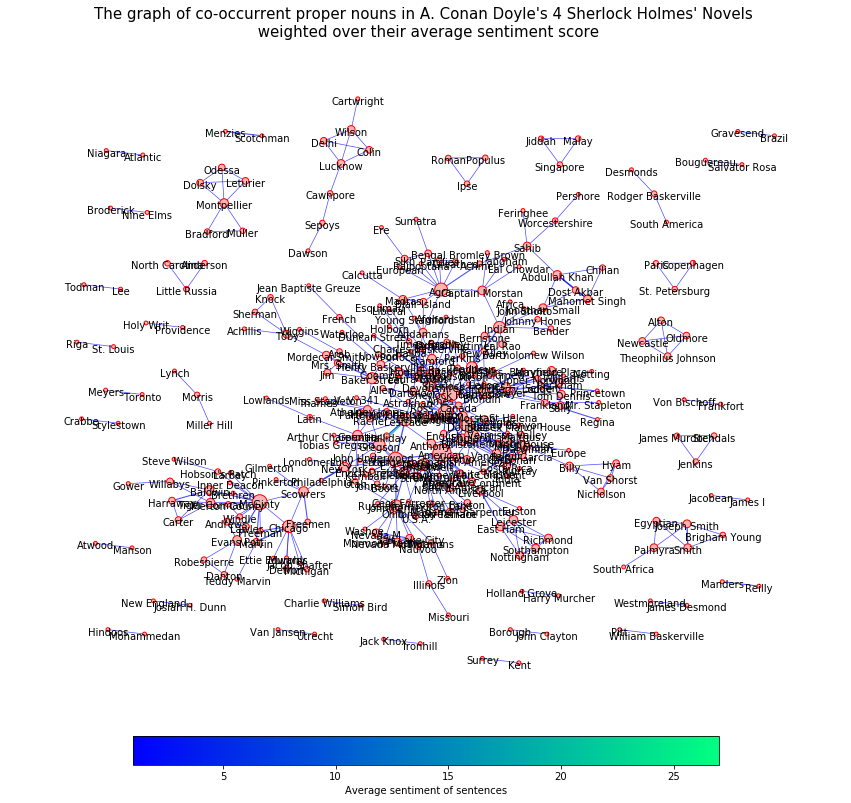

In [73]:
edge_width=[Gaw[u][v]['weight'] for u,v in Gaw.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.winter #cool
weight_list = [ e[2]['weight'] for e in Gaw.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[15*Gaw.degree(n) for n in Gaw.nodes()]

figsize=(15,15)

pos=graphviz_layout(Gaw) 
# pos=nx.spring_layout(Gw)

node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gaw, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gaw, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.7)
plt.axis('off');
yoffset = {}
y_off = -7 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gaw, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The graph of co-occurrent proper nouns in %s \n weighted over their average sentiment score" %titlename_all
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

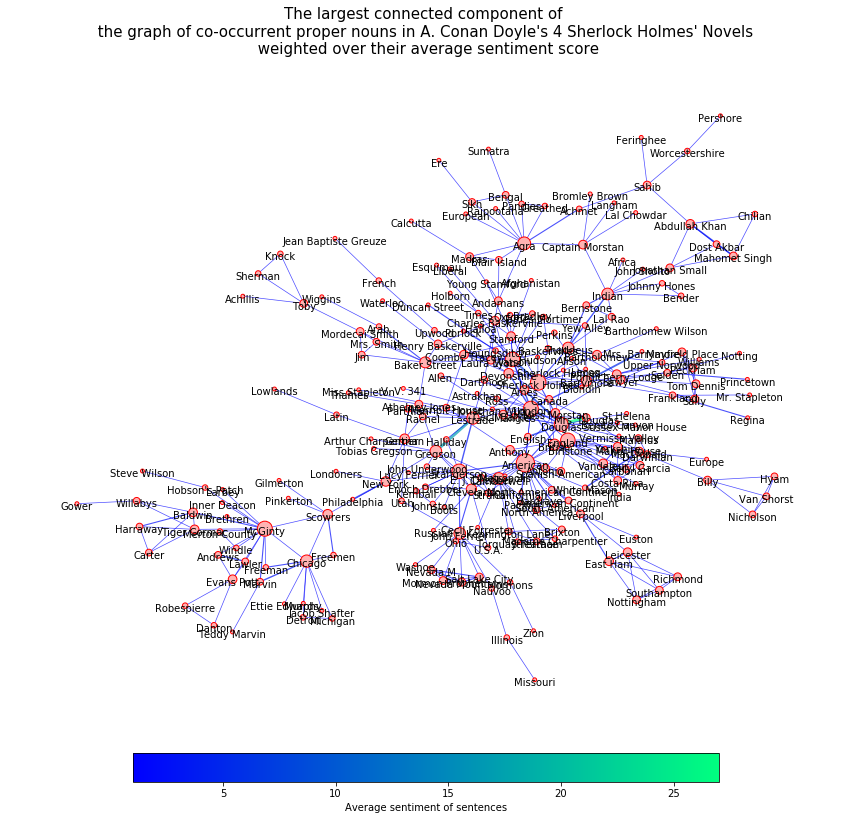

In [74]:
edge_width=[Gawlcc[u][v]['weight'] for u,v in Gawlcc.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.winter #cool
weight_list = [ e[2]['weight'] for e in Gawlcc.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[15*Gawlcc.degree(n) for n in Gawlcc.nodes()]

figsize=(15,15)
pos=graphviz_layout(Gawlcc) 
node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gawlcc, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gawlcc, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.7)
plt.axis('off');
yoffset = {}
y_off = -5 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gawlcc, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The largest connected component of \n the graph of co-occurrent proper nouns in %s \n weighted over their average sentiment score" %titlename_all
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

In [75]:
print("Run in %.2f seconds (%.2f minutes)" %(time.clock() - start_time,(time.clock() - start_time)/60))

Run in -373.96 seconds (-6.23 minutes)
